In [1]:
import xarray as xr
import xarray as xr
import datetime
import pandas as pd
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import numpy as np
from scipy.stats import linregress
from scipy import stats
from itertools import cycle
import cftime
from cmip_postprocess import *
from cmip_plot import plot_all_reg_cor_map
import warnings 
warnings.filterwarnings('ignore')

2025-02-03 11:05:13.385005


In [2]:
# Path to the data
SSTA_PATH = '../data/raw/SSTA/'
SSTA_INDEX_PATH = '../data/raw/SSTA_INDEX/'

source_id = '../data/raw/source_id.txt'

OUT_REG_PATH = '../data/processed/regression/'
OUT_FIG_PATH = '../results/figures/'

## 1. Plot the SSTA regression coefficient of the high skill models

In [3]:
regression_lpf_ssta_nta = load_from_pickle(OUT_REG_PATH + 'regression_lpf_ssta_nta.pkl')

In [4]:
# read the model ranking data
model_ranking = pd.read_csv('../tables/model_ranking.csv', index_col=0)

# sort the model by the distance value
model_ranking = model_ranking.sort_values('Distance')

# select the high skill models (Distance < 1) and low skill models (Distance > 1.5)
high_skill_models = model_ranking[model_ranking['Distance'] < 1].index.tolist()
high_skill_models = [model for model in high_skill_models if model != 'E3SMv2']
low_skill_models = model_ranking[model_ranking['Distance'] > 1.5].index.tolist()
low_skill_models = [model for model in low_skill_models if model != 'E3SM-MMF']


In [5]:

# calculate the ensemble mean for the high skill models
high_skill_data = [regression_lpf_ssta_nta[model] for model in high_skill_models if model in regression_lpf_ssta_nta]
high_skill_mean = sum(high_skill_data) / len(high_skill_data)




In [13]:
######################### Mask Threshold ##################################
r_threshold = 0.621489  # reference correlation based on the Pearson correlation table (df=780/120, alpha=0.1)

# Function to calculate the t-value and significance for model ensembles
def calculate_significance(models_data):
    r_values = np.array([data['r_value'] for model, data in models_data.items() if model not in ['E3SM-MMF', 'E3SMv2', 'HadISST', 'ERSST']])
    
    mean_correlation = np.mean(r_values, axis=0)
    std_dev = np.std(r_values, axis=0, ddof=1)
    n = len(r_values)
    standard_error = std_dev / np.sqrt(n)
    t_value = mean_correlation / standard_error
    degrees_of_freedom = n - 1
    alpha = 0.10
    critical_t_value = stats.t.ppf(1 - alpha / 2, degrees_of_freedom)
    significance_mask = abs(t_value) > critical_t_value
    return significance_mask


In [14]:

# Create dictionaries for high and low skill models, excluding E3SMv2 and E3SM-MMF respectively
high_skill_regression = {model: regression_lpf_ssta_nta[model] for model in high_skill_models if model in regression_lpf_ssta_nta and model != 'E3SMv2'}

# Calculate significance masks for high and low skill ensembles
high_skill_significance_mask = calculate_significance(high_skill_regression)


# Function to create significant mask and plot the dots for CMIP_MMM
def plot_significant_dots_cmip_mmm(ax, data, lons, lats, significance_mask, thinning_factor=6):
    stipple_lons, stipple_lats = np.meshgrid(lons, lats)
    thin_mask = significance_mask[::thinning_factor, ::thinning_factor]
    thin_stipple_lons = stipple_lons[::thinning_factor, ::thinning_factor]
    thin_stipple_lats = stipple_lats[::thinning_factor, ::thinning_factor]
    ax.scatter(thin_stipple_lons[thin_mask], thin_stipple_lats[thin_mask], 
               color='k', marker='.', s=5, alpha=0.6, transform=ccrs.PlateCarree())  # Adjust size `s` and transparency `alpha` as needed

# Function to create significant mask and plot the dots
def plot_significant_dots(ax, data, lons, lats, threshold=0.621489, thinning_factor=6):
    significant_mask = abs(data['r_value']) >= threshold
    stipple_lons, stipple_lats = np.meshgrid(lons, lats)
    thin_mask = significant_mask[::thinning_factor, ::thinning_factor]
    thin_stipple_lons = stipple_lons[::thinning_factor, ::thinning_factor]
    thin_stipple_lats = stipple_lats[::thinning_factor, ::thinning_factor]
    ax.scatter(thin_stipple_lons[thin_mask], thin_stipple_lats[thin_mask], 
               color='k', marker='.', s=5, alpha=0.6, transform=ccrs.PlateCarree())  # Adjust size `s` and transparency `alpha` as needed


NameError: name 'regression_lpf_ssta_nta' is not defined

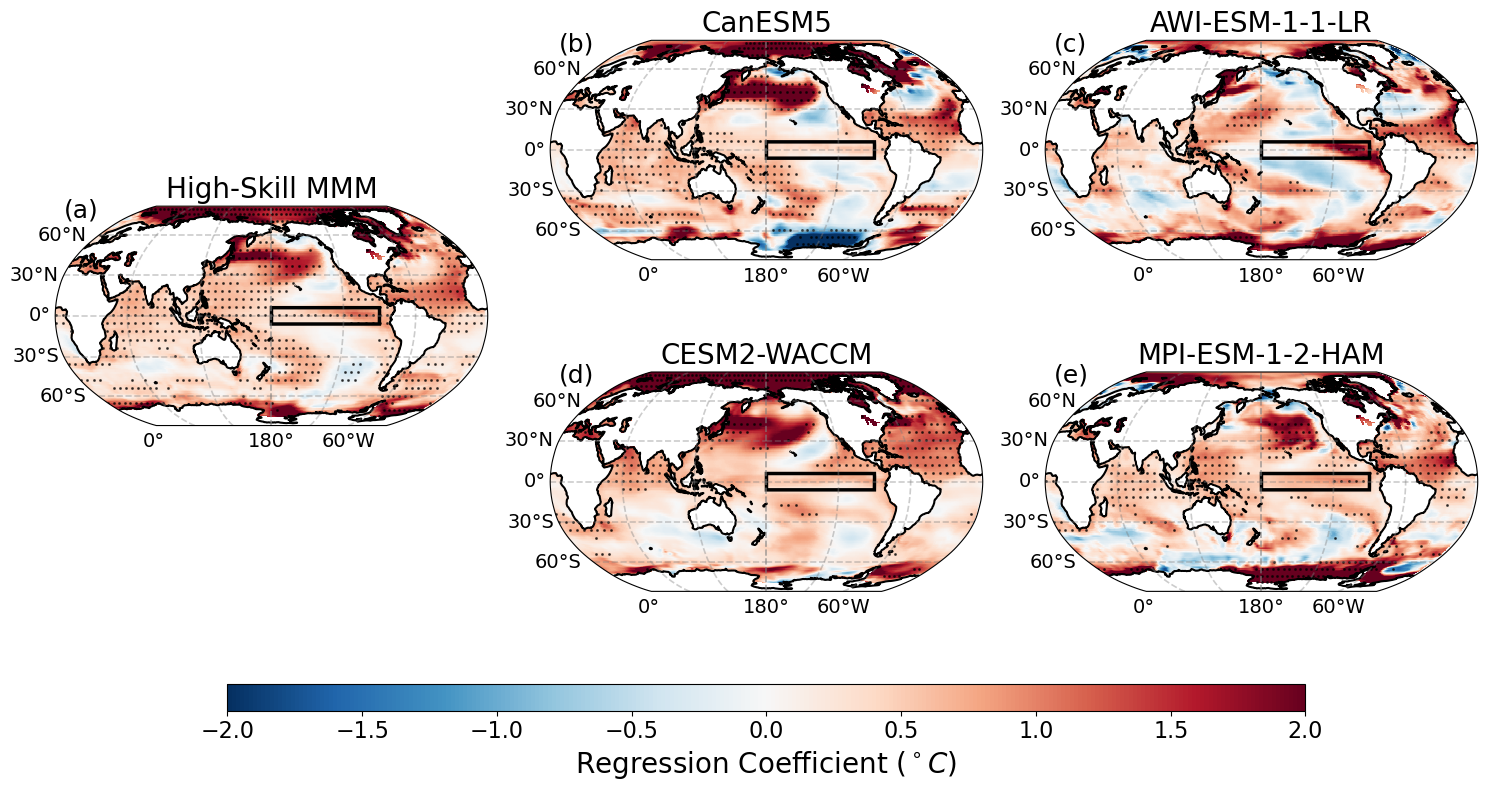

In [18]:
import matplotlib.gridspec as gridspec

# Create figure with GridSpec
fig = plt.figure(figsize=(15, 8))

# Create a GridSpec with 4 rows and 3 columns
# The extra rows allow us to center the MMM plot
gs = gridspec.GridSpec(4, 3, figure=fig, height_ratios=[1, 1, 1, 1])

# Create axes with custom layout
axes = []

# Create the large plot in the first column spanning middle rows (centered vertically)
ax_mmm = fig.add_subplot(gs[1:3, 0], projection=ccrs.Robinson(central_longitude=180))
axes.append(ax_mmm)

# Create the four smaller plots in the second and third columns
# Top row
ax_top1 = fig.add_subplot(gs[0:2, 1], projection=ccrs.Robinson(central_longitude=180))
ax_top2 = fig.add_subplot(gs[0:2, 2], projection=ccrs.Robinson(central_longitude=180))
# Bottom row
ax_bottom1 = fig.add_subplot(gs[2:4, 1], projection=ccrs.Robinson(central_longitude=180))
ax_bottom2 = fig.add_subplot(gs[2:4, 2], projection=ccrs.Robinson(central_longitude=180))

axes.extend([ax_top1, ax_top2, ax_bottom1, ax_bottom2])

# Plot the ensemble mean regression results for high skill models (MMM)
im = high_skill_mean['slope'].plot(ax=axes[0], transform=ccrs.PlateCarree(), 
                                 cmap='RdBu_r', vmin=-2, vmax=2, add_colorbar=False)

# Plot individual high skill models in separate panels
for i, model in enumerate(high_skill_models[:4], start=1):  # Plot first 4 high skill models
    if model in regression_lpf_ssta_nta:
        im = regression_lpf_ssta_nta[model]['slope'].plot(ax=axes[i], 
                                                         transform=ccrs.PlateCarree(), 
                                                         cmap='RdBu_r', vmin=-2, vmax=2, 
                                                         add_colorbar=False)

# Add coastlines and gridlines for context
for ax in axes:
    ax.coastlines(linewidth=1.5)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, 
                     linewidth=1.2, color='gray', alpha=0.4, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 14}
    gl.ylabel_style = {'size': 14}

# Set titles for the subplots
titles = ['High-Skill MMM'] + [model for model in high_skill_models[:4]]
for i, title in enumerate(titles):
    axes[i].set_title(title, fontsize=20)

# Add subplot labels
labels = ['(a)', '(b)', '(c)', '(d)', '(e)']
for i, label in enumerate(labels):
    axes[i].text(0.02, 0.95, label, transform=axes[i].transAxes, fontsize=18)

# Plot significant dots for MMM
lon, lat = regression_lpf_ssta_nta['ERSST']['lon'], regression_lpf_ssta_nta['ERSST']['lat']
plot_significant_dots_cmip_mmm(axes[0], high_skill_mean, lon, lat, high_skill_significance_mask)

# Plot significant dots for individual models
for i, model in enumerate(high_skill_models[:4], start=1):
    if model in regression_lpf_ssta_nta:
        plot_significant_dots(axes[i], regression_lpf_ssta_nta[model], lon, lat, threshold=0.621489)

# Add CTI regions
for ax in axes:
    cti_box = mpatches.Rectangle((180, -6), 90, 12, fill=False, 
                                edgecolor='black', linewidth=2.5,
                                transform=ccrs.PlateCarree())
    ax.add_patch(cti_box)

# Adjust layout
plt.tight_layout()


# Add a colorbar
cbar = fig.colorbar(im, ax=axes, orientation='horizontal',
                   fraction=0.035,
                   pad=0.12,
                   aspect=40)
label = 'Regression Coefficient $(^\circ C)$'
cbar.set_label(label, fontsize=20)
cbar.ax.tick_params(labelsize=16)

plt.show()

## 2. Plot the Walker circulation regression coefficient of the high skill models

In [5]:
path = '../data/processed/regression/'

reg_nta_omega_cmip = load_from_pickle(path+'regression_omega_ano_nta.pkl')
reg_cti_omega_cmip = load_from_pickle(path+'regression_omega_ano_cti.pkl')

CMIP6_MODLES = '../data/raw/source_id.txt'

In [6]:
def get_input_names(cmip_model=None):
    with open(cmip_model, "r") as f:
        lines = f.readlines()
    return lines

cmip_models = get_input_names(CMIP6_MODLES)

models_extend = ['ERA5', 'E3SM-MMF', 'E3SMv2']

In [13]:
# Calculate ensemble mean for high and low skill models
high_skill_omega_nta = {}
high_skill_omega_cti = {}
low_skill_omega_nta = {}
low_skill_omega_cti = {}

# First get a reference model to get the correct coordinates
ref_model = list(reg_nta_omega_cmip.keys())[1]
ref_coords = {
    'plev': reg_nta_omega_cmip[ref_model]['slope'].plev,
    'lon': reg_nta_omega_cmip[ref_model]['slope'].lon
}

# Calculate means for each variable
for var in ['slope', 'intercept', 'r_value', 'p_value', 'std_err']:
    # For NTA
    high_skill_nta_data = np.stack([reg_nta_omega_cmip[model][var].values 
                                   for model in high_skill_models 
                                   if model in reg_nta_omega_cmip])
    high_skill_omega_nta[var] = xr.DataArray(
        np.nanmean(high_skill_nta_data, axis=0),
        coords={
            'plev': ref_coords['plev'],
            'lon': ref_coords['lon']
        },
        dims=['plev', 'lon']
    )
    
    low_skill_nta_data = np.stack([reg_nta_omega_cmip[model][var].values 
                                   for model in low_skill_models 
                                   if model in reg_nta_omega_cmip])
    low_skill_omega_nta[var] = xr.DataArray(
        np.nanmean(low_skill_nta_data, axis=0),
        coords={
            'plev': ref_coords['plev'],
            'lon': ref_coords['lon']
        },
        dims=['plev', 'lon']
    )

    # For CTI
    high_skill_cti_data = np.stack([reg_cti_omega_cmip[model][var].values 
                                   for model in high_skill_models 
                                   if model in reg_cti_omega_cmip])
    high_skill_omega_cti[var] = xr.DataArray(
        np.nanmean(high_skill_cti_data, axis=0),
        coords={
            'plev': ref_coords['plev'],
            'lon': ref_coords['lon']
        },
        dims=['plev', 'lon']
    )

    low_skill_cti_data = np.stack([reg_cti_omega_cmip[model][var].values 
                                   for model in low_skill_models 
                                   if model in reg_cti_omega_cmip])
    low_skill_omega_cti[var] = xr.DataArray(
        np.nanmean(low_skill_cti_data, axis=0),
        coords={
            'plev': ref_coords['plev'],
            'lon': ref_coords['lon']
        },
        dims=['plev', 'lon']
    )

# Convert to xarray datasets
high_skill_omega_nta = xr.Dataset(high_skill_omega_nta)
high_skill_omega_cti = xr.Dataset(high_skill_omega_cti)
low_skill_omega_nta = xr.Dataset(low_skill_omega_nta)
low_skill_omega_cti = xr.Dataset(low_skill_omega_cti)
    
# Add to regression dictionaries
reg_nta_omega_cmip['High-Skill-MMM'] = high_skill_omega_nta
reg_cti_omega_cmip['High-Skill-MMM'] = high_skill_omega_cti
reg_nta_omega_cmip['Low-Skill-MMM'] = low_skill_omega_nta
reg_cti_omega_cmip['Low-Skill-MMM'] = low_skill_omega_cti

### calculate the significance mask for High-Skill-MMM and Low-Skill-MMM

In [8]:
r_threshold = 0.621489  # reference correlation based on the Pearson correlation table (df=780/120, alpha=0.1)

# Function to calculate the t-value and significance for model groups
def calculate_significance(models_list, reg_data):
    r_values = np.array([reg_data[model]['r_value'].values for model in models_list 
                        if model in reg_data])
    
    mean_correlation = np.mean(r_values, axis=0)
    std_dev = np.std(r_values, axis=0, ddof=1)
    n = len(r_values)
    standard_error = std_dev / np.sqrt(n)
    t_value = mean_correlation / standard_error
    degrees_of_freedom = n - 1
    alpha = 0.10
    critical_t_value = stats.t.ppf(1 - alpha / 2, degrees_of_freedom)
    significance_mask = abs(t_value) > critical_t_value
    return significance_mask


In [9]:

# Calculate significance masks for high-skill and low-skill model groups
high_skill_mmm_significance_mask = calculate_significance(high_skill_models, reg_nta_omega_cmip)
high_skill_cti_significance_mask = calculate_significance(high_skill_models, reg_cti_omega_cmip)

low_skill_mmm_significance_mask = calculate_significance(low_skill_models, reg_nta_omega_cmip)
low_skill_cti_significance_mask = calculate_significance(low_skill_models, reg_cti_omega_cmip)


lons, levs = np.meshgrid(reg_nta_omega_cmip['High-Skill-MMM']['lon'], reg_nta_omega_cmip['High-Skill-MMM']['plev'])

# create a xarray.Dataset to save the significance mask
significance_mask_ds_nta_high = xr.Dataset(
    {
        "significance_mask": (["plev", "lon"], high_skill_mmm_significance_mask)
    },
    coords={
        "lon": reg_nta_omega_cmip['High-Skill-MMM']['lon'],
        "lev": reg_nta_omega_cmip['High-Skill-MMM']['plev']
    }
)

significance_mask_ds_cti_high = xr.Dataset(
    {
        "significance_mask": (["plev", "lon"], high_skill_cti_significance_mask)
    },
    coords={
        "lon": reg_cti_omega_cmip['High-Skill-MMM']['lon'],
        "lev": reg_cti_omega_cmip['High-Skill-MMM']['plev']
    }
)



In [10]:
# please plot the mmf for trop and nh and sh using subplot
def convert_to_hPa(tick_value, pos):
    return int(tick_value / 100)

def plot_wind_profile(ds, left_title='CMIP6-MMM', right_title='OMEGA-NTA', vmin=-0.01, vmax=0.01, interval=0.001, threshold=0.621489, significance_mask_ds=None):
    fig, ax = plt.subplots(figsize=(15, 6), dpi=200)
    if 'plev' in ds.dims:
        ds = ds.rename({'plev': 'lev'})
        ax.yaxis.set_major_formatter(plt.FuncFormatter(convert_to_hPa))
        # if cmip model, please make the y-axis pressure in hPa
        ax.yaxis.set_major_formatter(plt.FuncFormatter(convert_to_hPa))
        y_position = 950*100
        ax.text(55, y_position, 'Indian', fontsize=20, fontweight='bold')
        ax.text(130, y_position, 'WP', fontsize=20, fontweight='bold')
        ax.text(220, y_position, 'CEP', fontsize=20, fontweight='bold')
        ax.text(300, y_position, 'Atlantic', fontsize=20, fontweight='bold')
    else:
        # if reanalysis,do not change the y-axis pressure
        y_position = 950
        ax.text(55, y_position, 'Indian', fontsize=20, fontweight='bold')
        ax.text(130, y_position, 'WP', fontsize=20, fontweight='bold')
        ax.text(220, y_position, 'CEP', fontsize=20, fontweight='bold')
        ax.text(300, y_position, 'Atlantic', fontsize=20, fontweight='bold')
        
    levels = np.arange(vmin, vmax+interval, interval)
    cf = ax.contourf(ds['lon'], ds['lev'], ds['slope'].values, cmap='RdBu_r', levels=levels, extend='both')
    # please plot all the values in the levels, not use contourf, use imshow

    cbar = plt.colorbar(cf, ax=ax, pad=0.02, extend='both')
    cbar.ax.tick_params(labelsize=14)  # Set colorbar label size
    # cbar.set_label('Correlation Coefficient', fontsize=14, fontweight='bold') 
    cbar.set_label('Regression Coefficient (Pa/s)', fontsize=14, fontweight='bold') 
    plt.title(left_title, loc='left', fontweight='bold', fontsize=20)
    plt.title(right_title, loc='right',fontweight='bold', fontsize=20)


    ax.axvline(30, color='k', linestyle='--')   
    ax.axvline(110, color='k', linestyle='--')
    ax.axvline(180, color='k', linestyle='--')
    ax.axvline(280, color='k', linestyle='--')


    ax.set_xlabel('Longitude', fontsize=20)
    ax.set_ylabel('Pressure (hPa)', fontsize=20)

    # ax.set_ylim(0, 1000)
    ax.invert_yaxis()
    # ax.grid(True)
    # please make the ticks width larger, linewidth=2
    ax.tick_params(axis='both', which='major', labelsize=20, width=3)
    ax.tick_params(axis='both', which='minor', labelsize=20, width=3)

    ax.set_xlim(0, 360)
    # please make the edge of the axis thicker and value text larger

    # make the x-axis number larger
    ax.xaxis.set_tick_params(width=3)
    ax.yaxis.set_tick_params(width=3)

    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(4)
    

    # please implement a function to the significant dots based on the r_threshold
    # which the mask region is (lon lev) region, meaning the significant dots are in the (lon, lev) space
    if left_title in ['High-Skill MMM', 'Low-Skill MMM']:
        plot_significant_dots_cmip_mmm(ax, significance_mask_ds)
    else:
        plot_mask(ax, ds, threshold)

# Function to create significant mask and plot the dots for CMIP_MMM
def plot_significant_dots_cmip_mmm(ax, ds):
    lons, levs = np.meshgrid(ds['lon'], ds['plev'])
    significant_mask = ds['significance_mask']
    thinning_factor_lon = 5
    thin_mask = significant_mask[:, ::thinning_factor_lon]
    thin_lons = lons[:, ::thinning_factor_lon]
    thin_levs = levs[:, ::thinning_factor_lon]
    ax.scatter(thin_lons[thin_mask], thin_levs[thin_mask],
                color='k', marker='.', s=3, alpha=0.6)
    
def plot_mask(ax, ds, threshold=0.621489):

    lons, levs = np.meshgrid(ds['lon'], ds['lev'])
    
    # create the significance mask, consider the positive and negative values
    significant_mask = np.abs(ds['r_value'].values) >= threshold
    
    # only sparse the longitude
    thinning_factor_lon = 5  # only sparse the longitude
    thin_mask = significant_mask[:, ::thinning_factor_lon]
    thin_lons = lons[:, ::thinning_factor_lon]
    thin_levs = levs[:, ::thinning_factor_lon]
    
    # plot the dots in the significant region
    ax.scatter(thin_lons[thin_mask], 
            thin_levs[thin_mask],
            color='k', 
            marker='.', 
            s=3, 
            alpha=0.6)


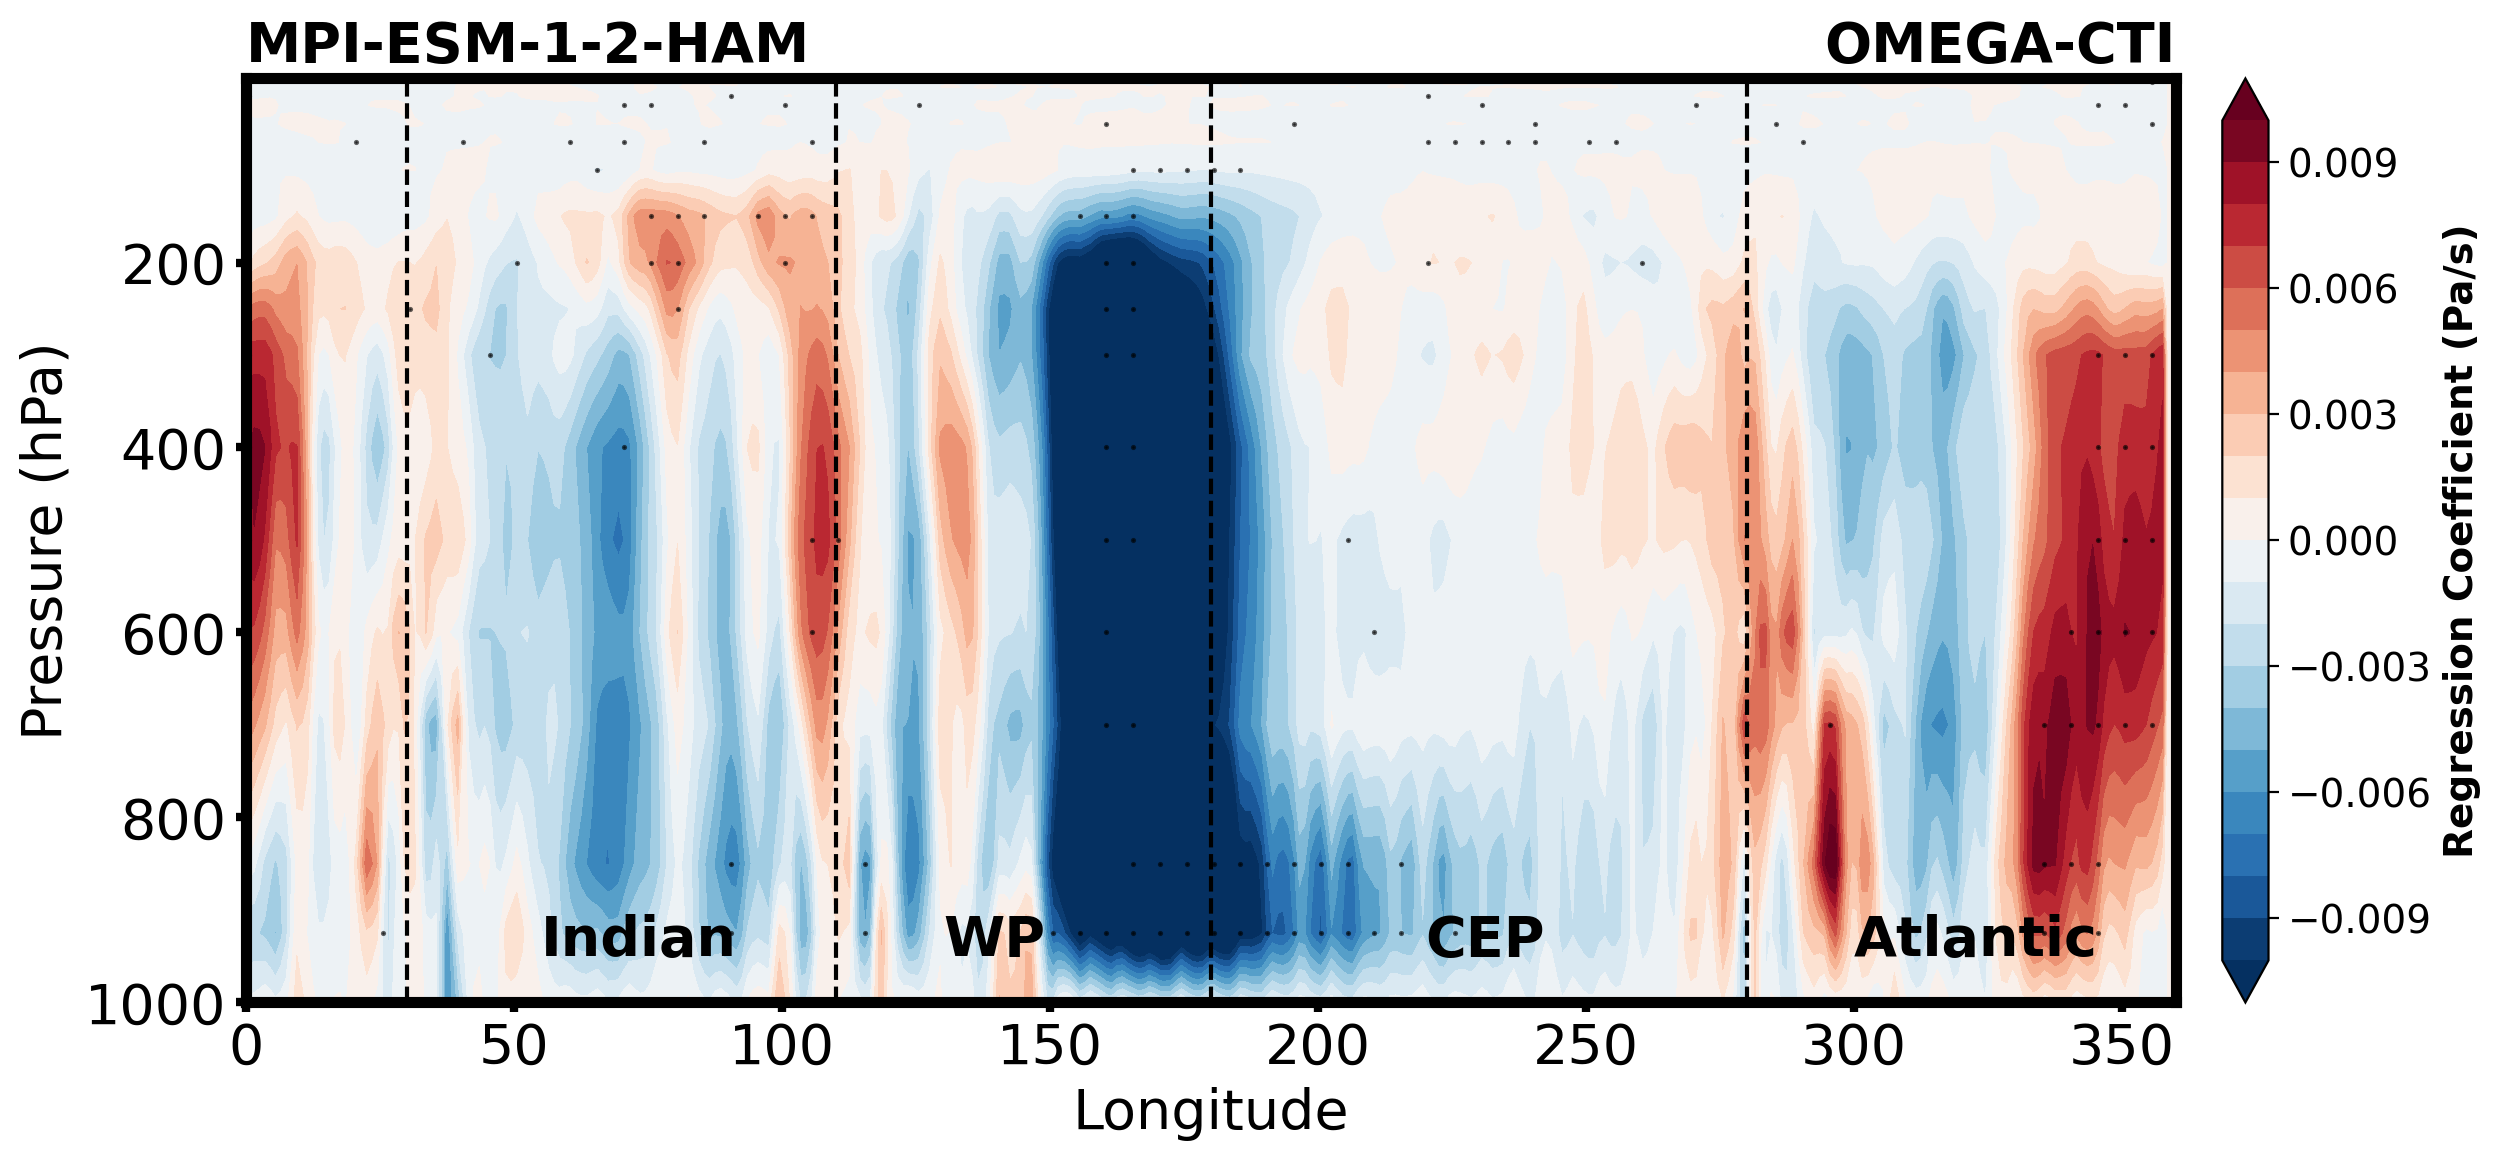

In [12]:
plot_wind_profile(reg_cti_omega_cmip[model], left_title=model, right_title='OMEGA-CTI', vmin=-0.01, vmax=0.01, interval=0.001, threshold=0.621489)


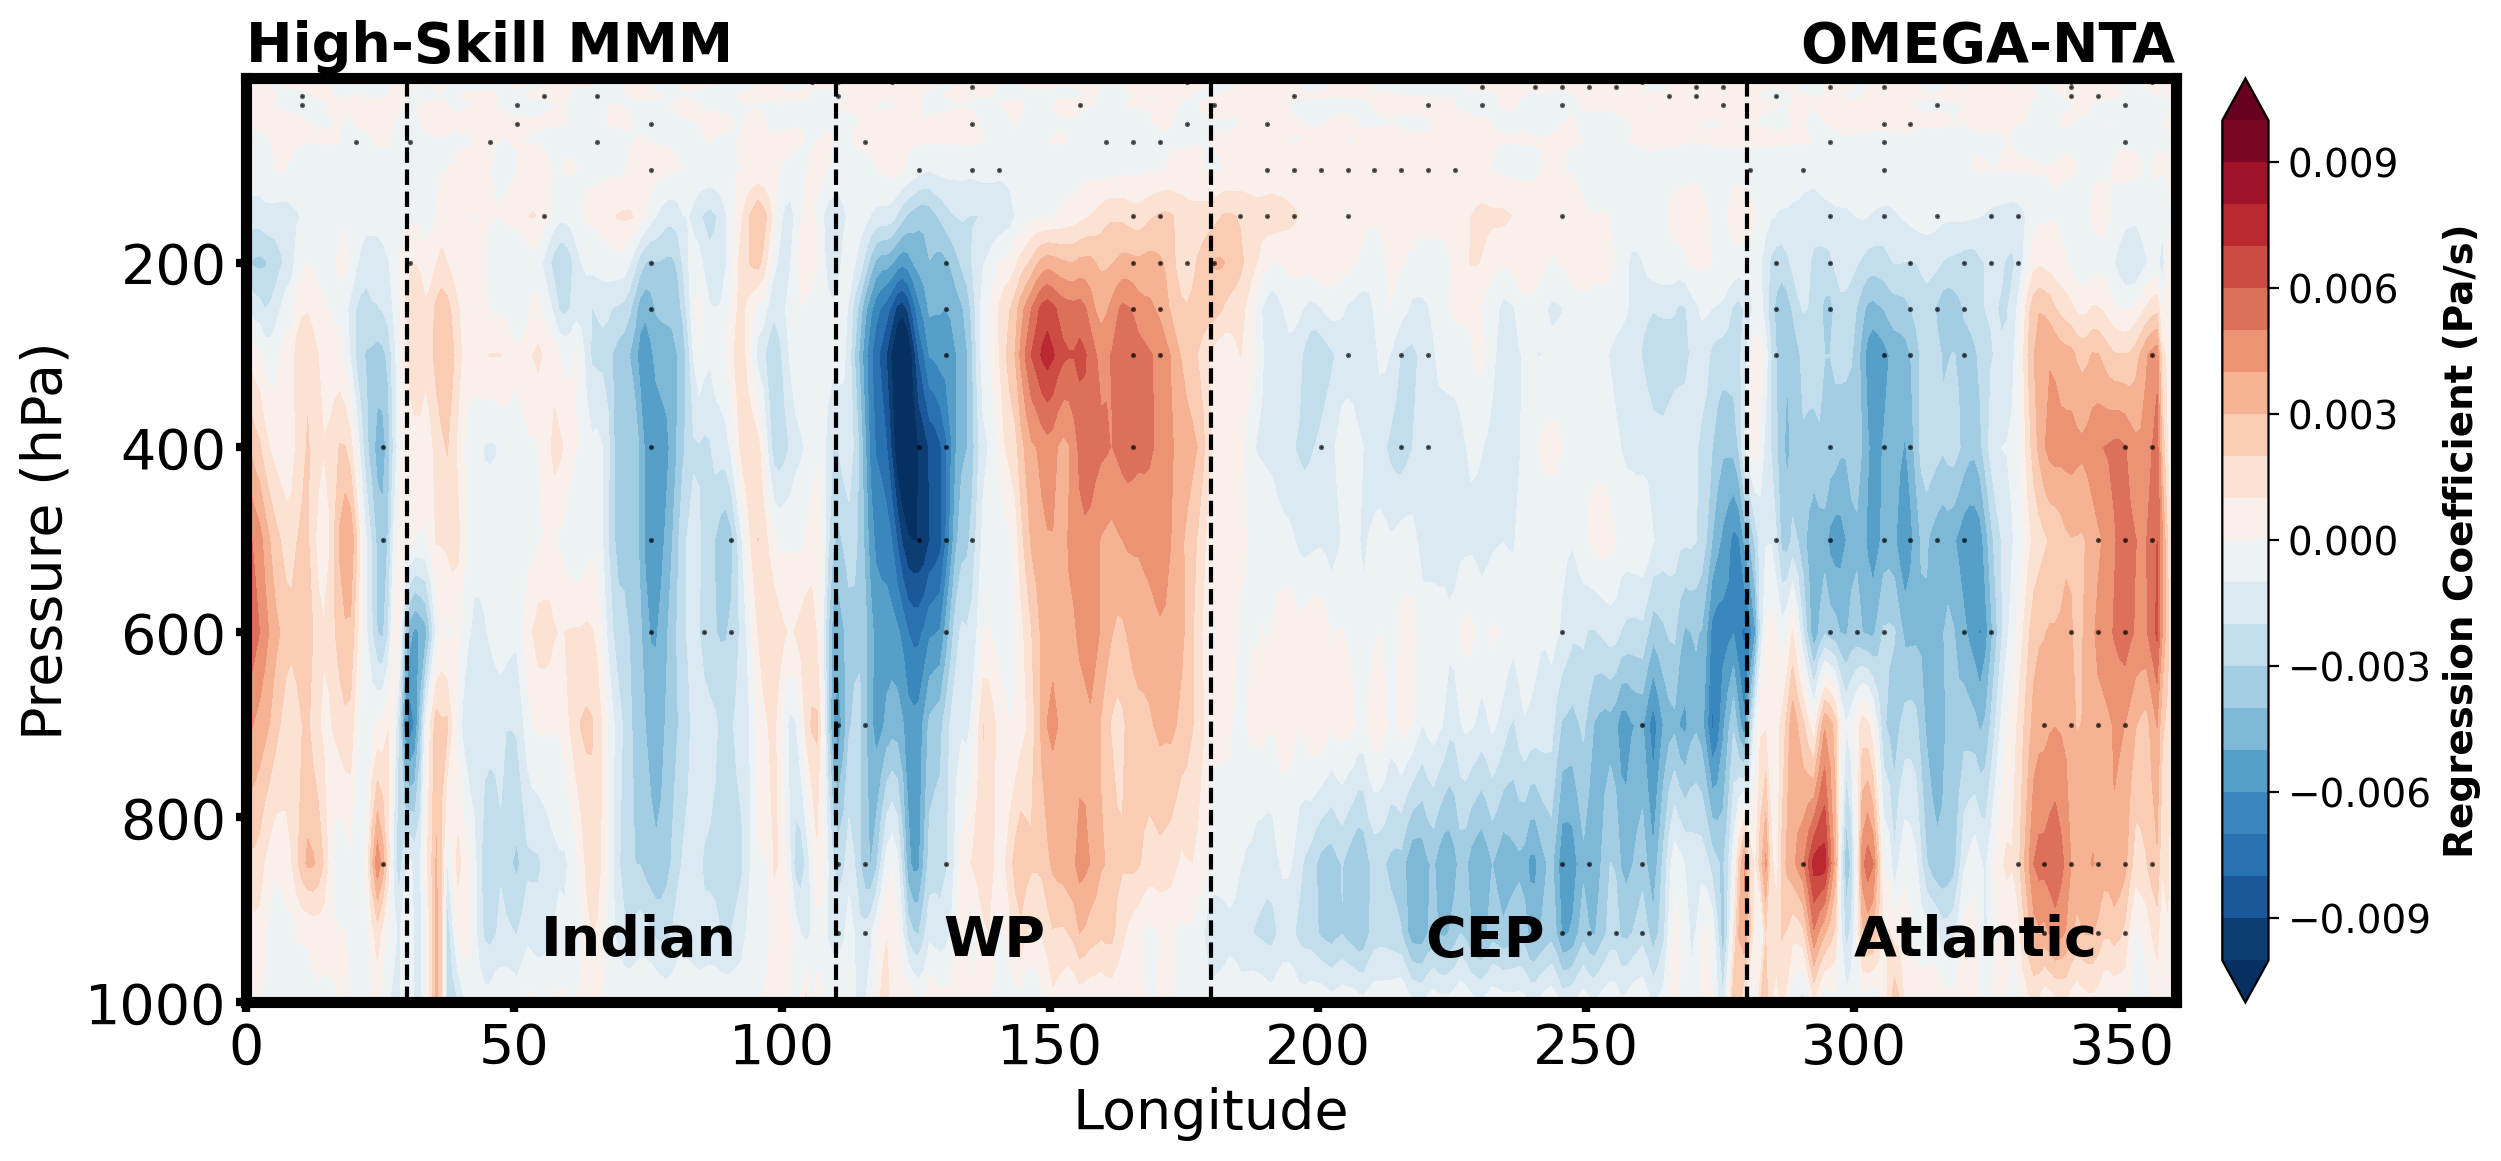

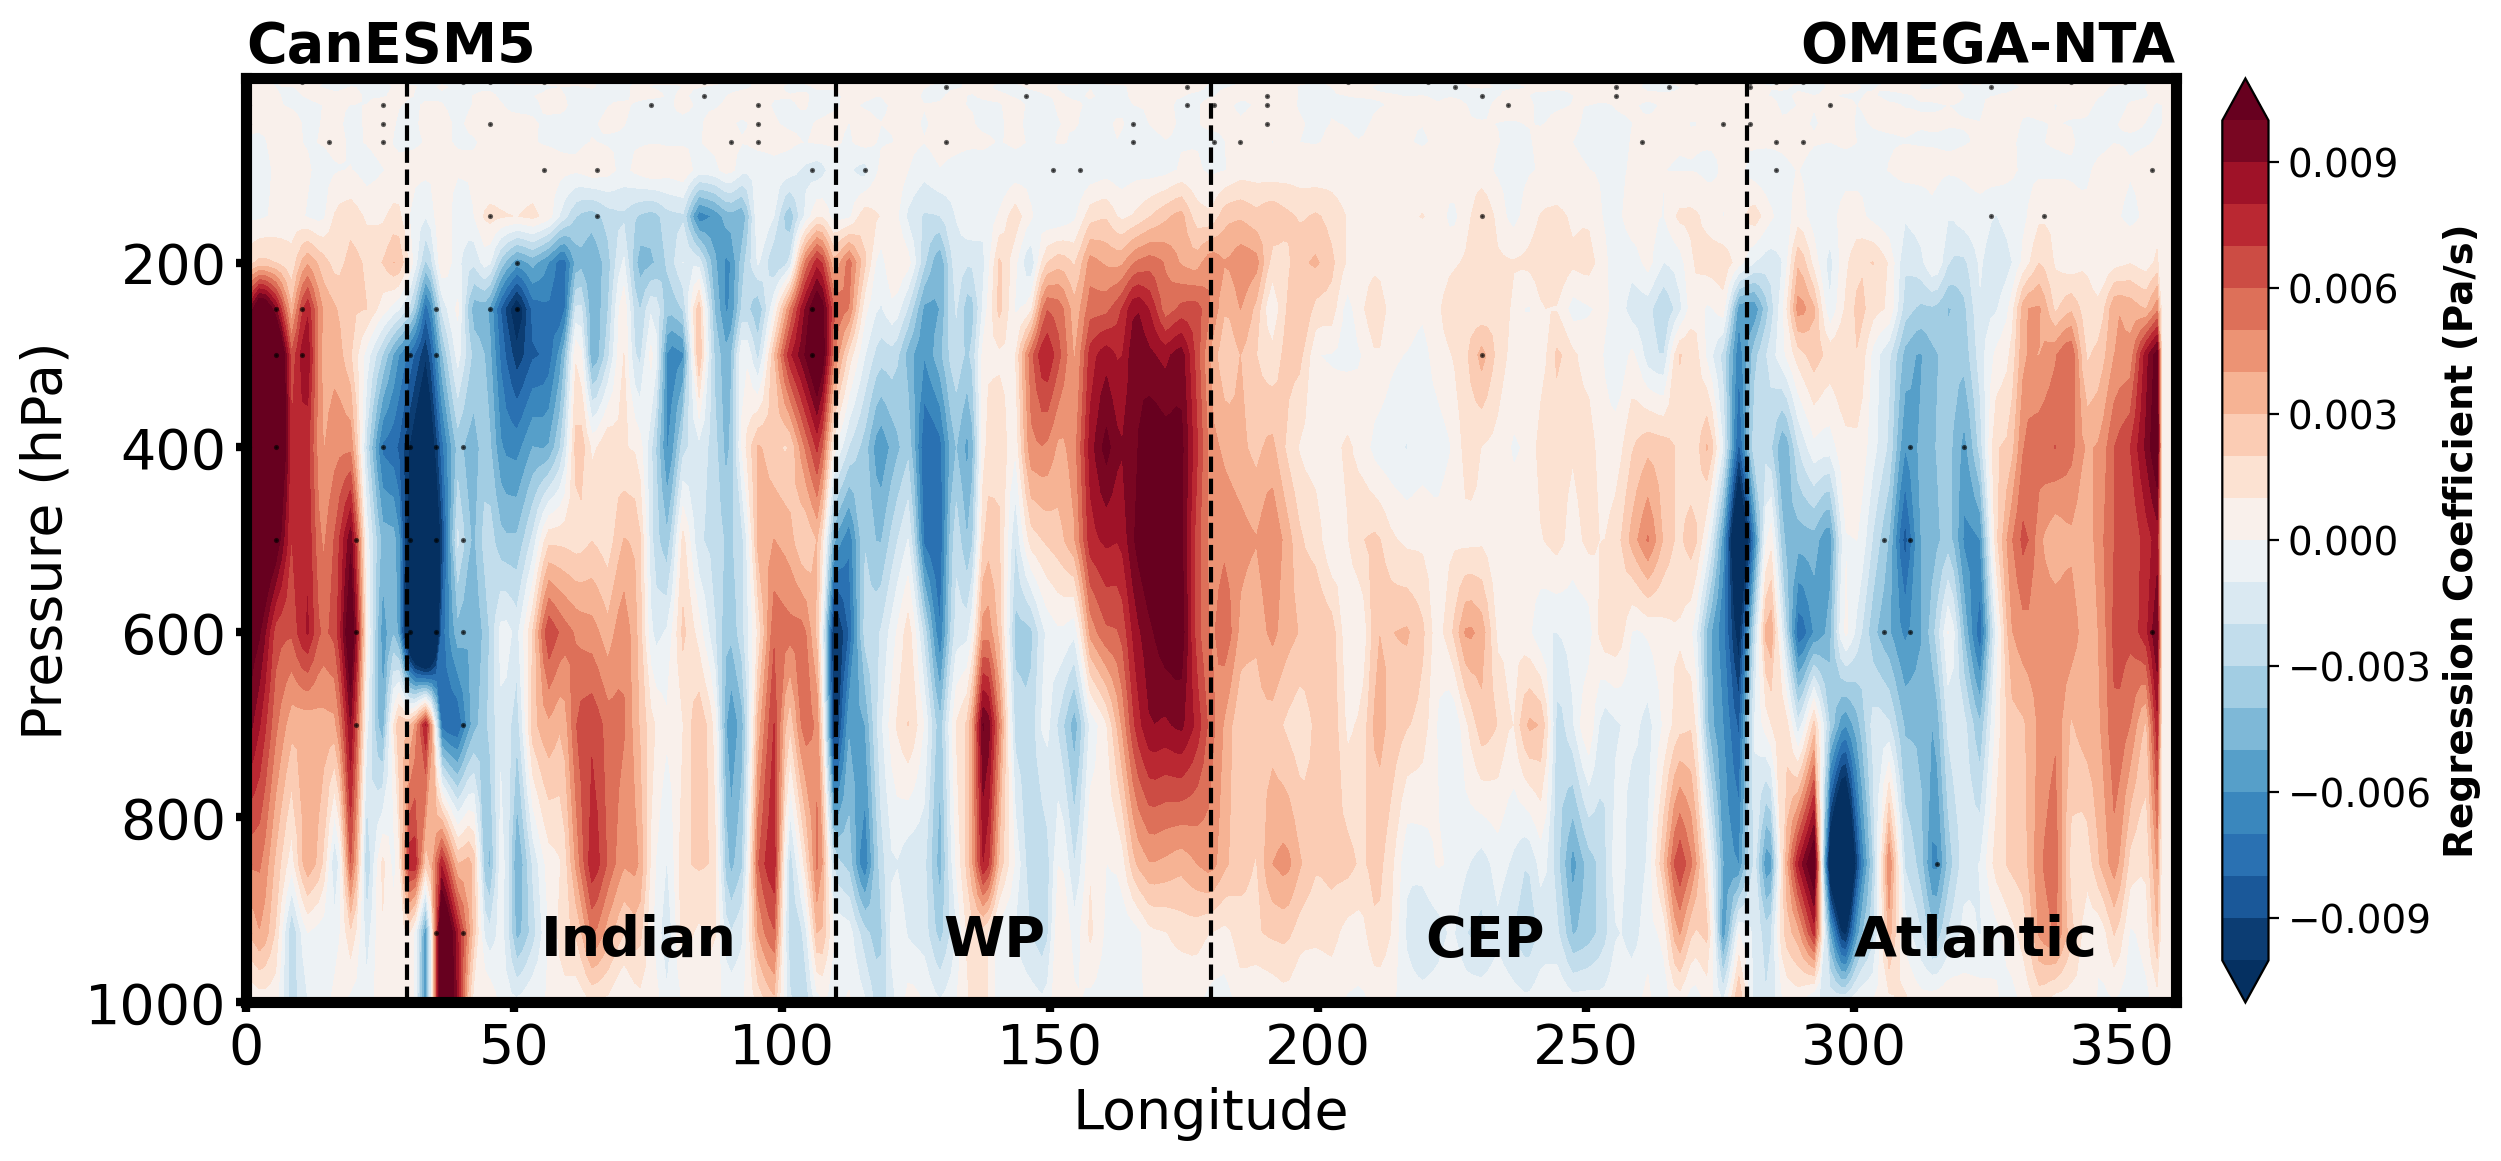

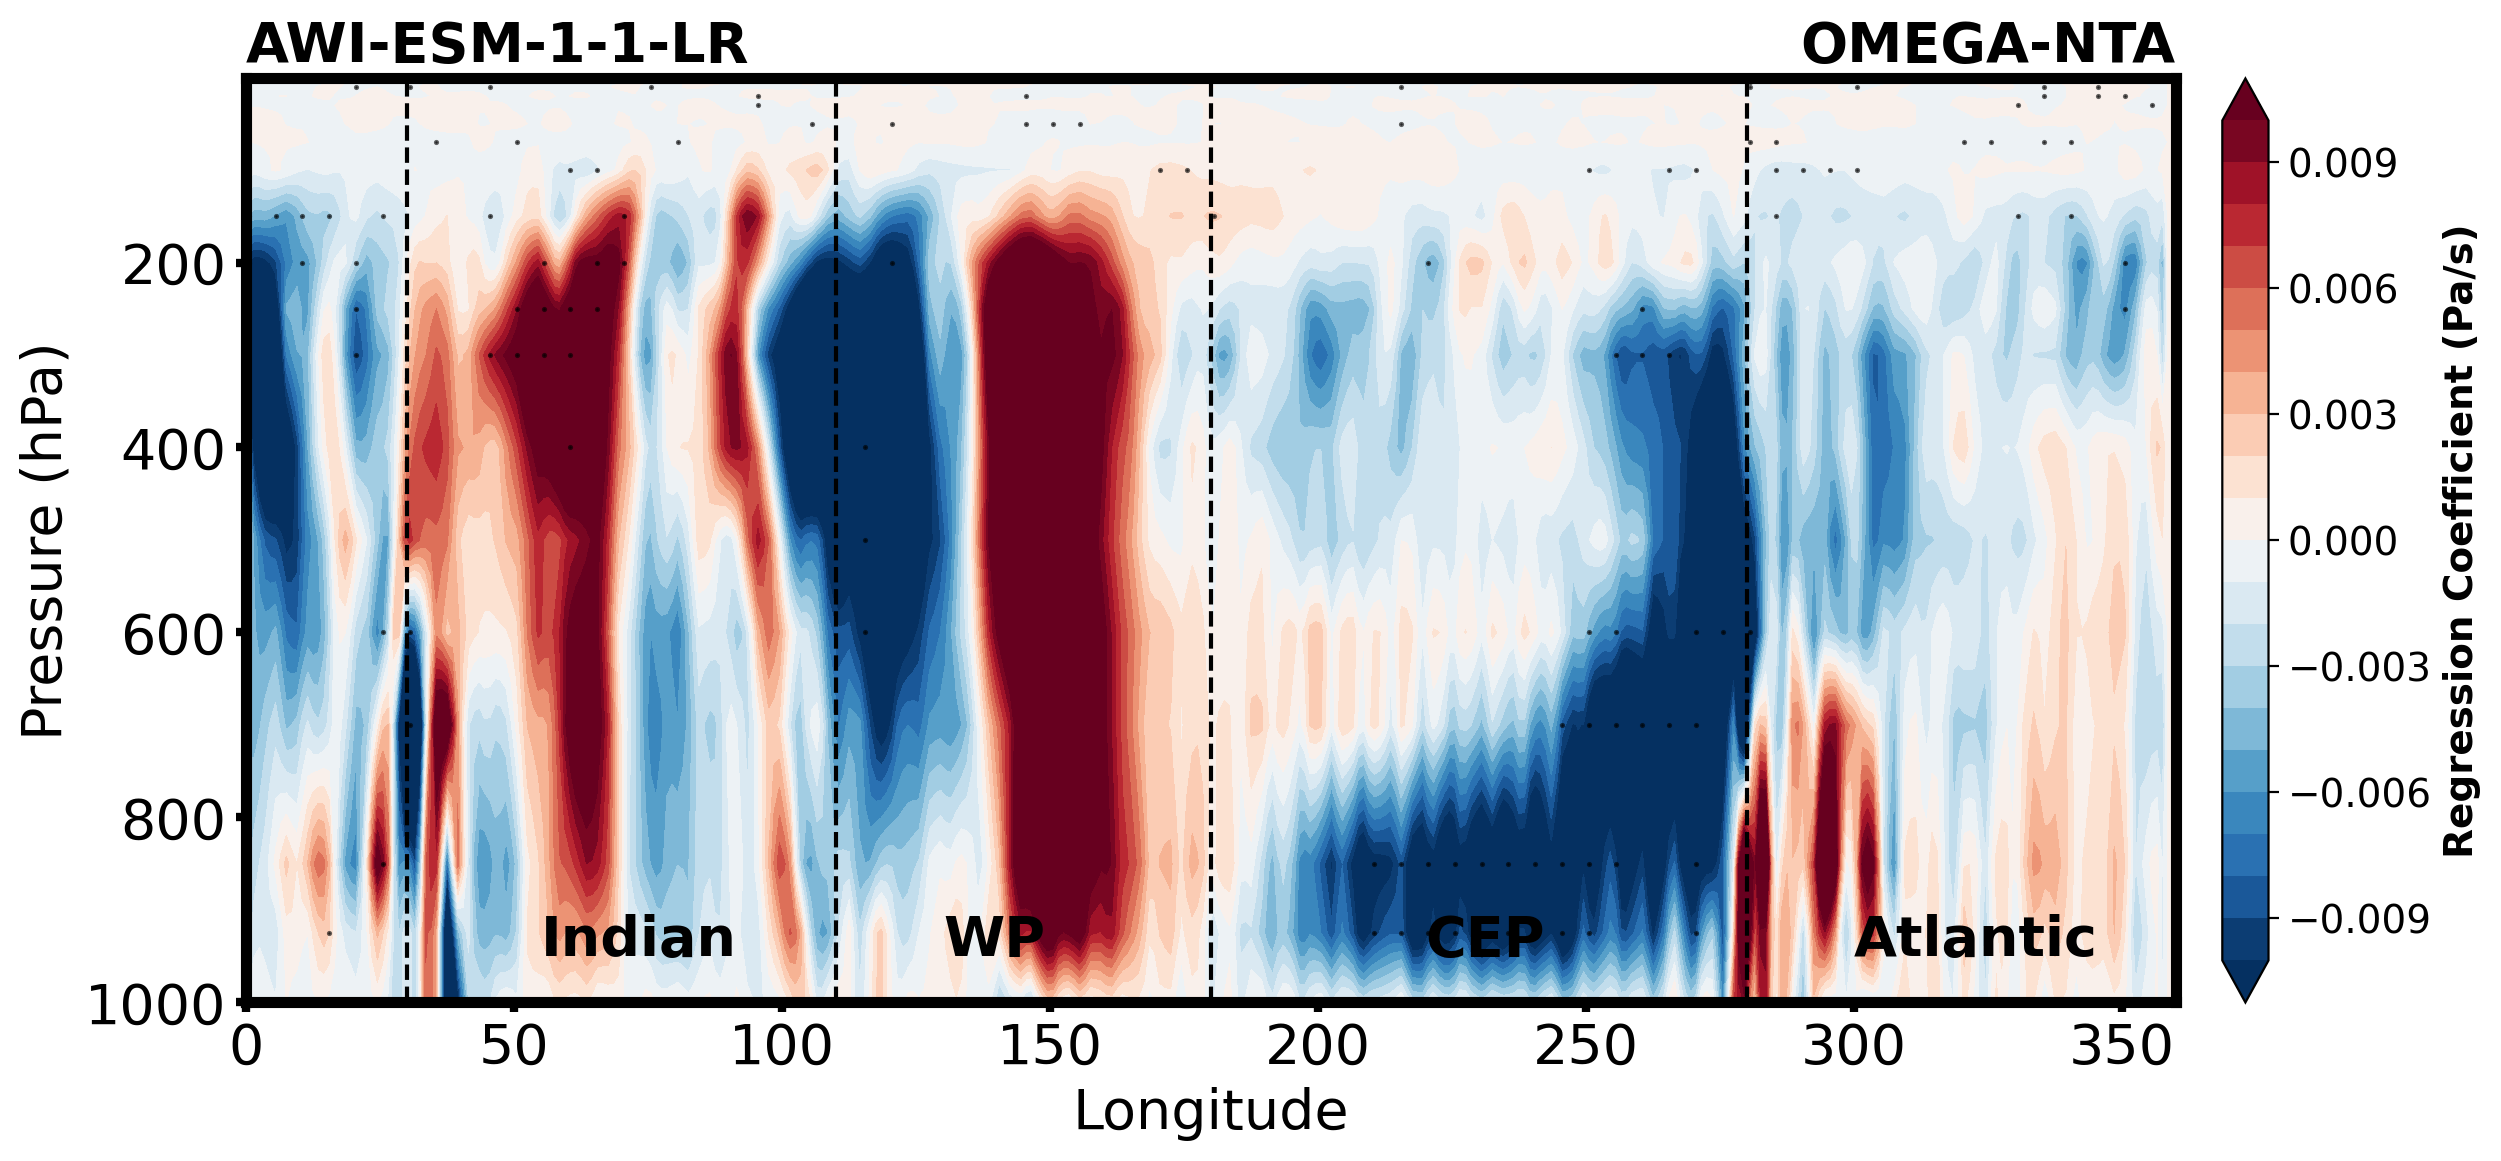

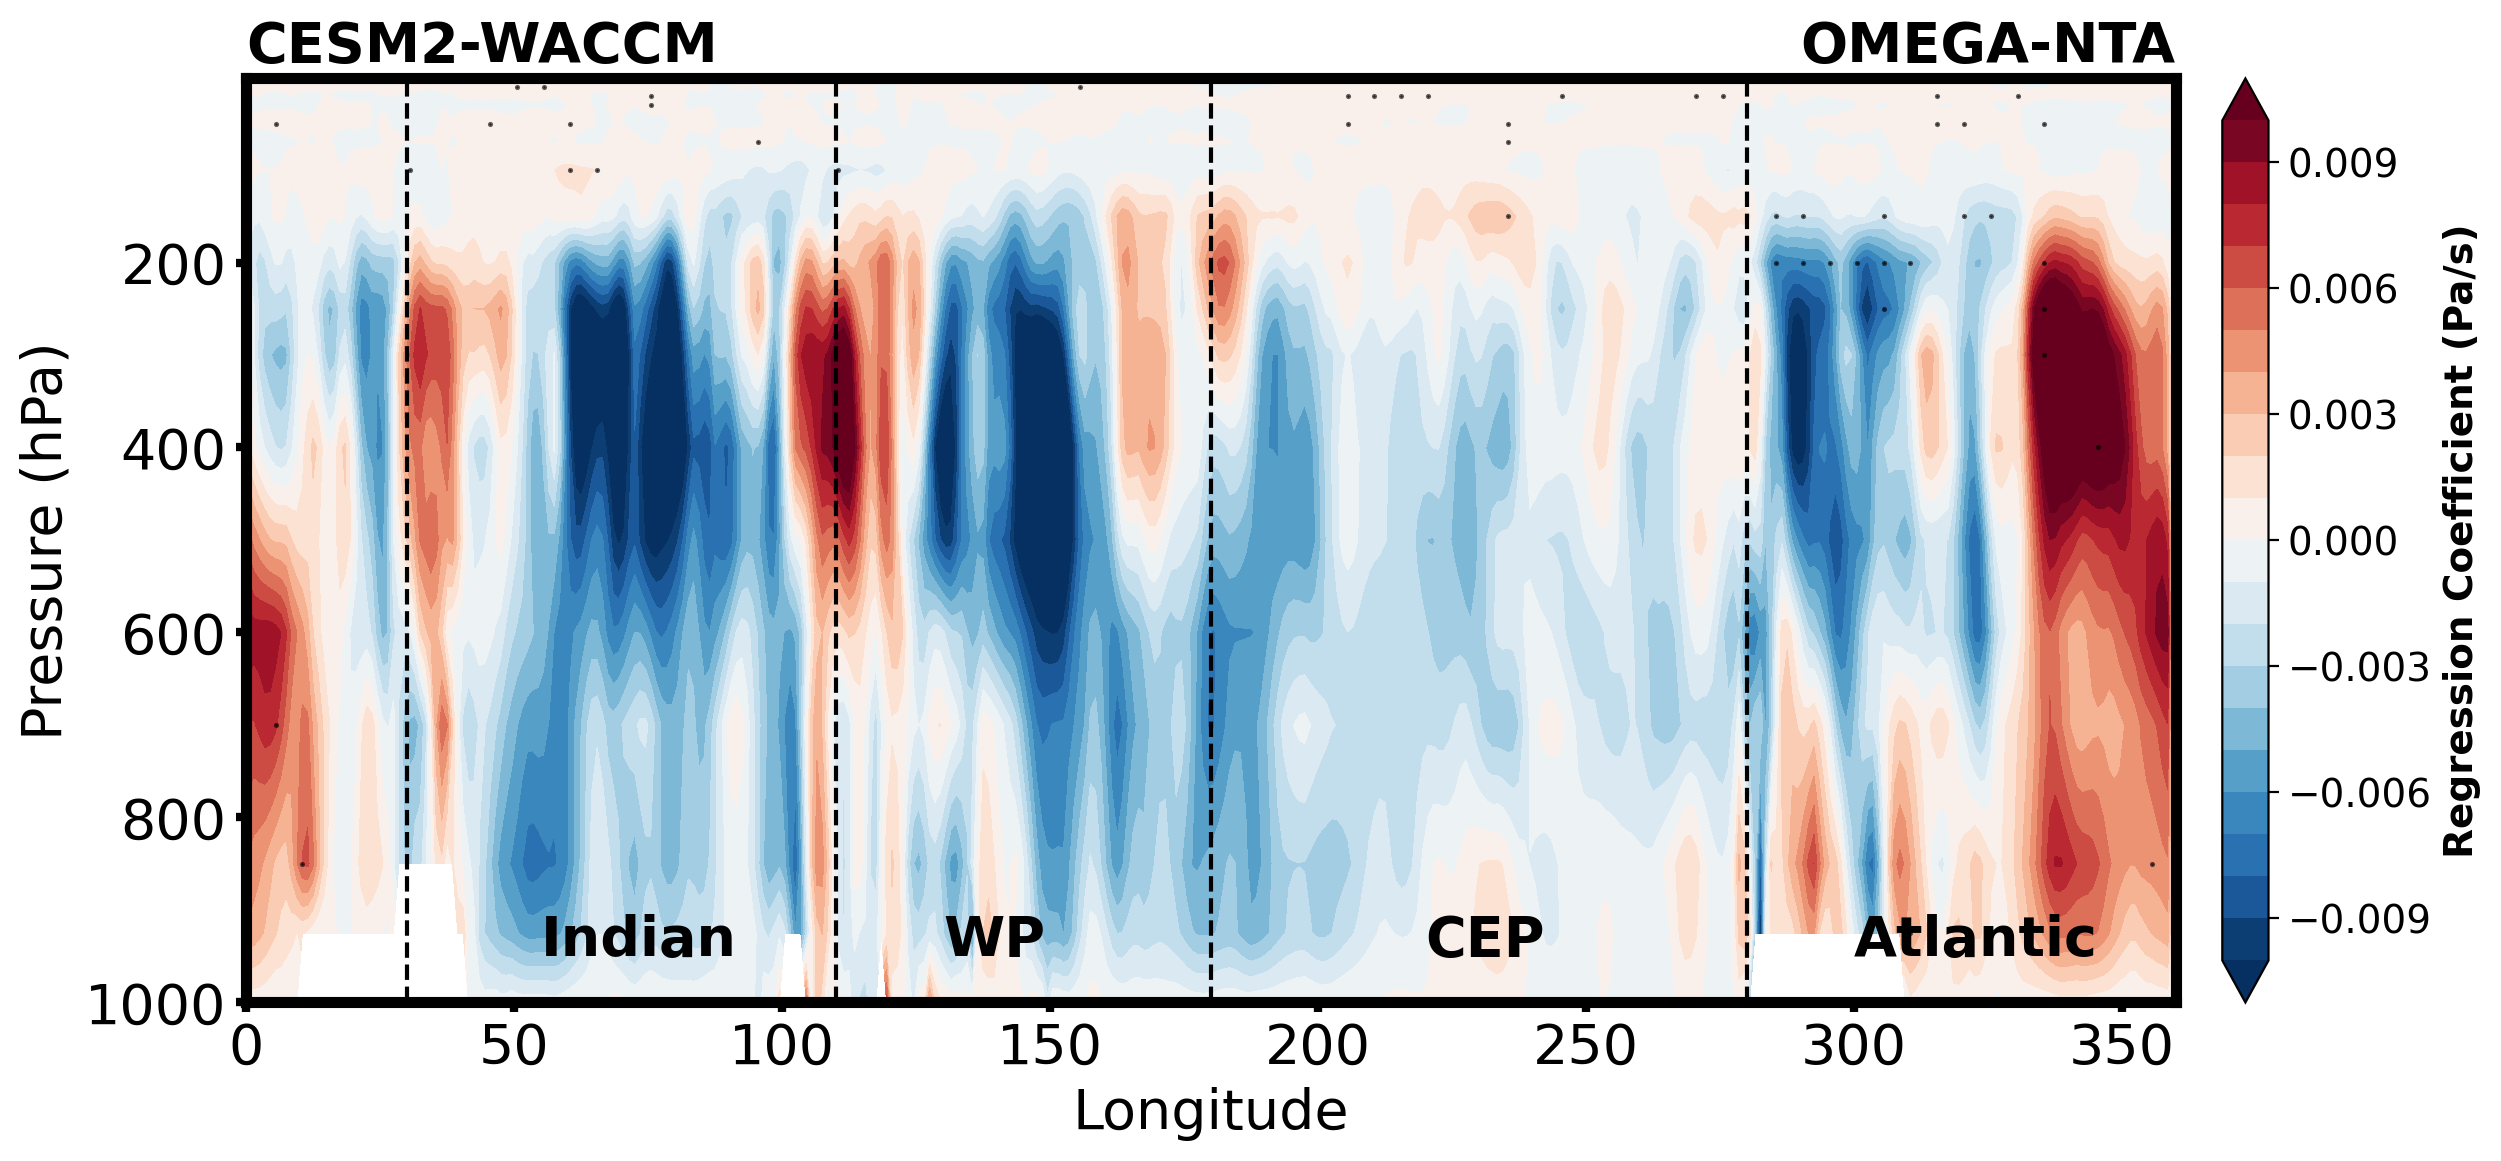

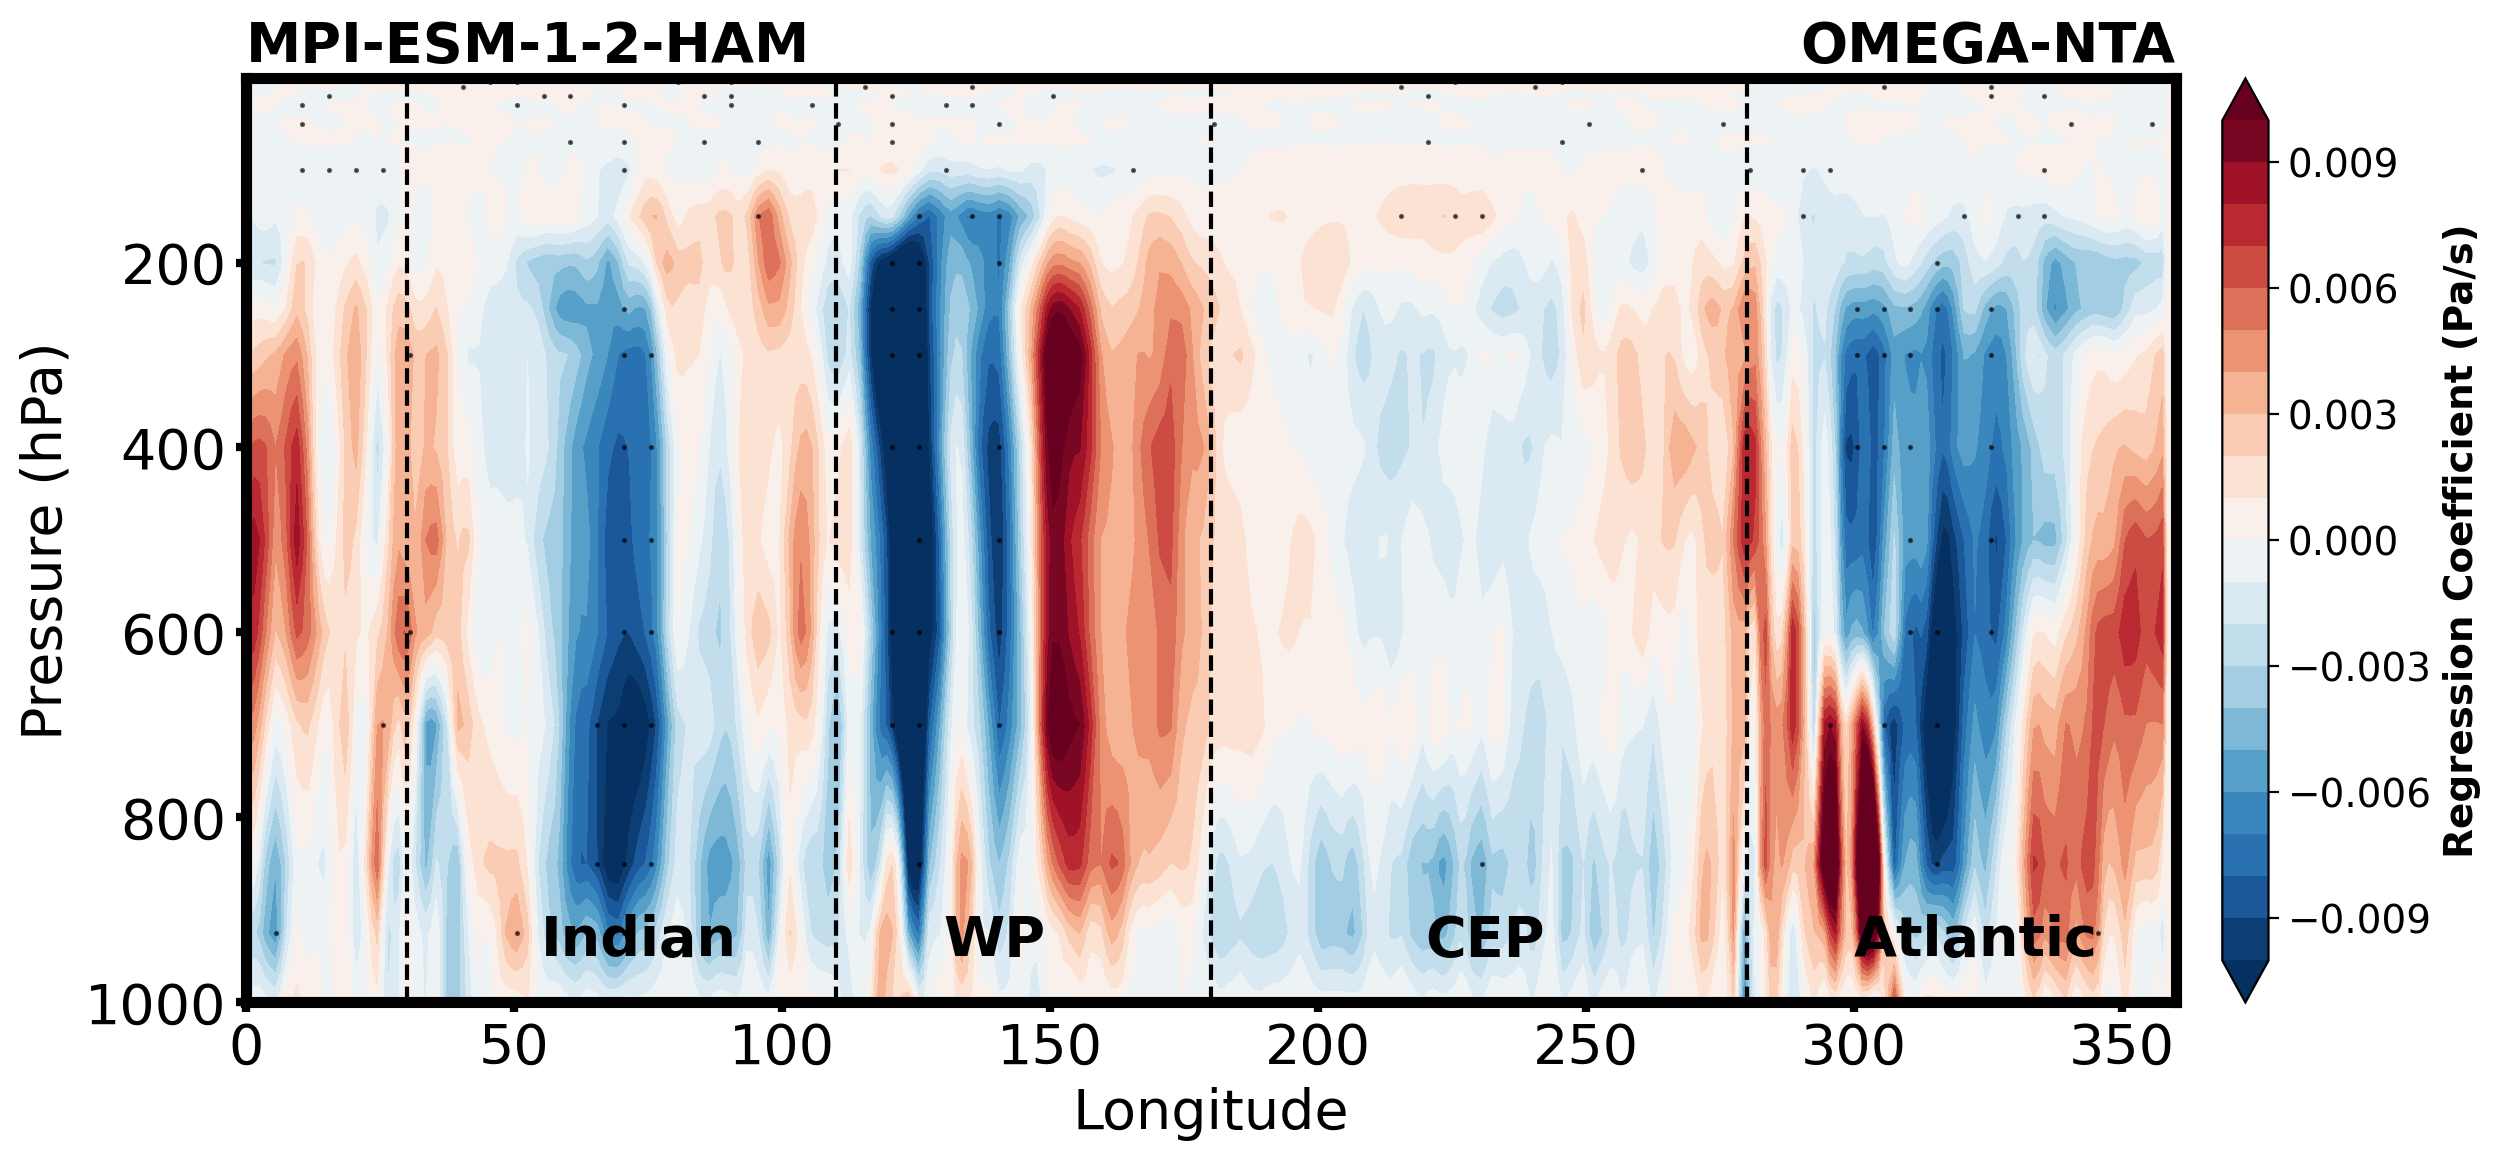

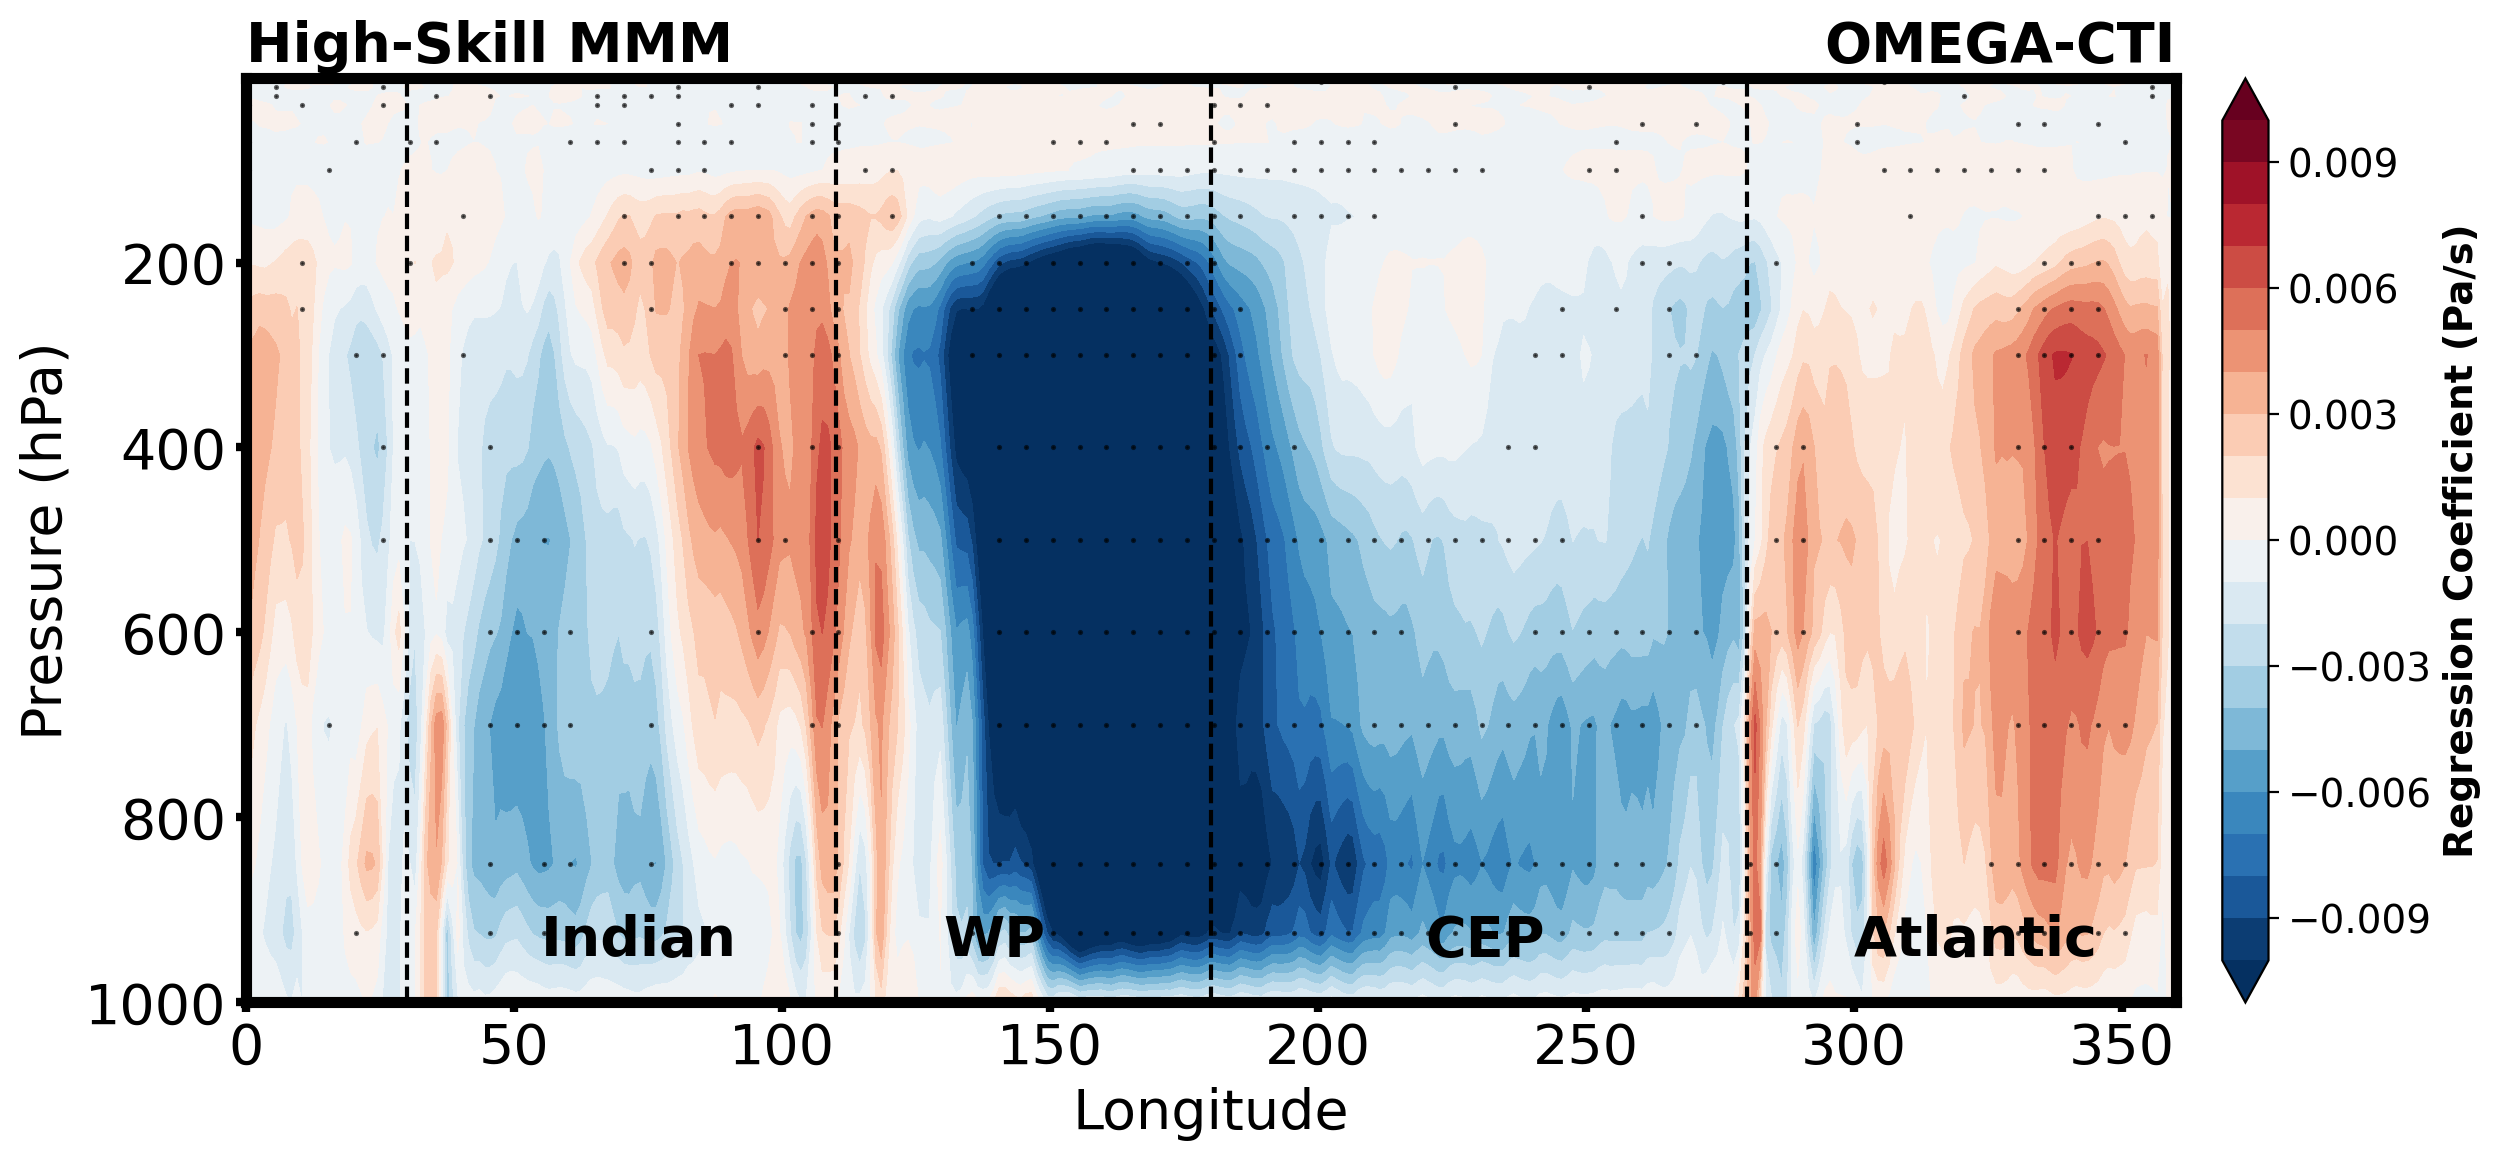

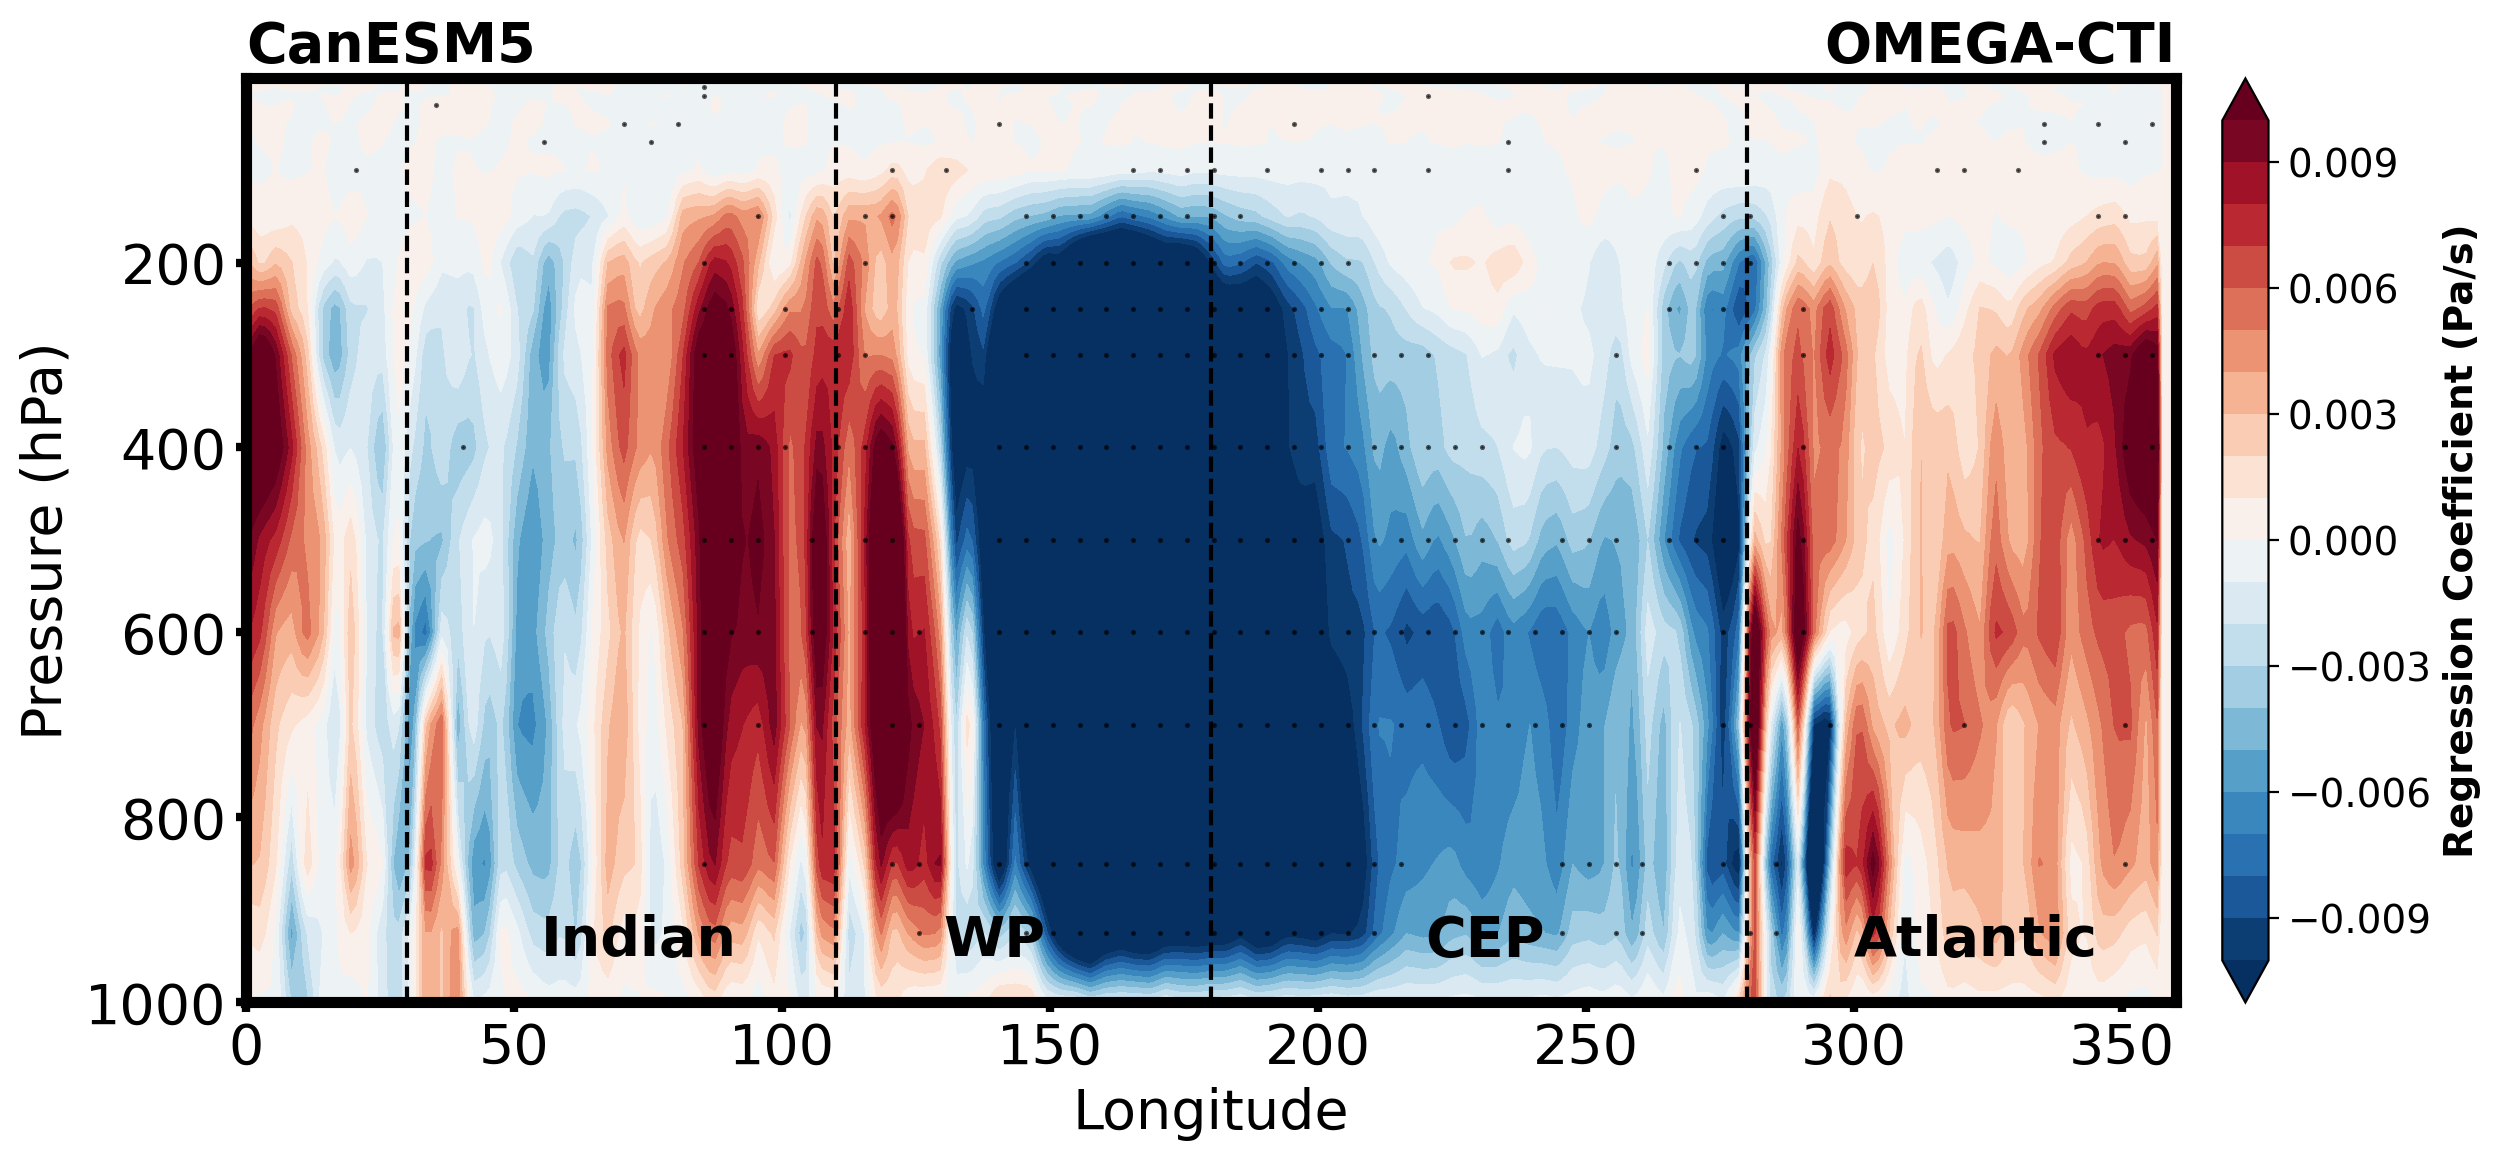

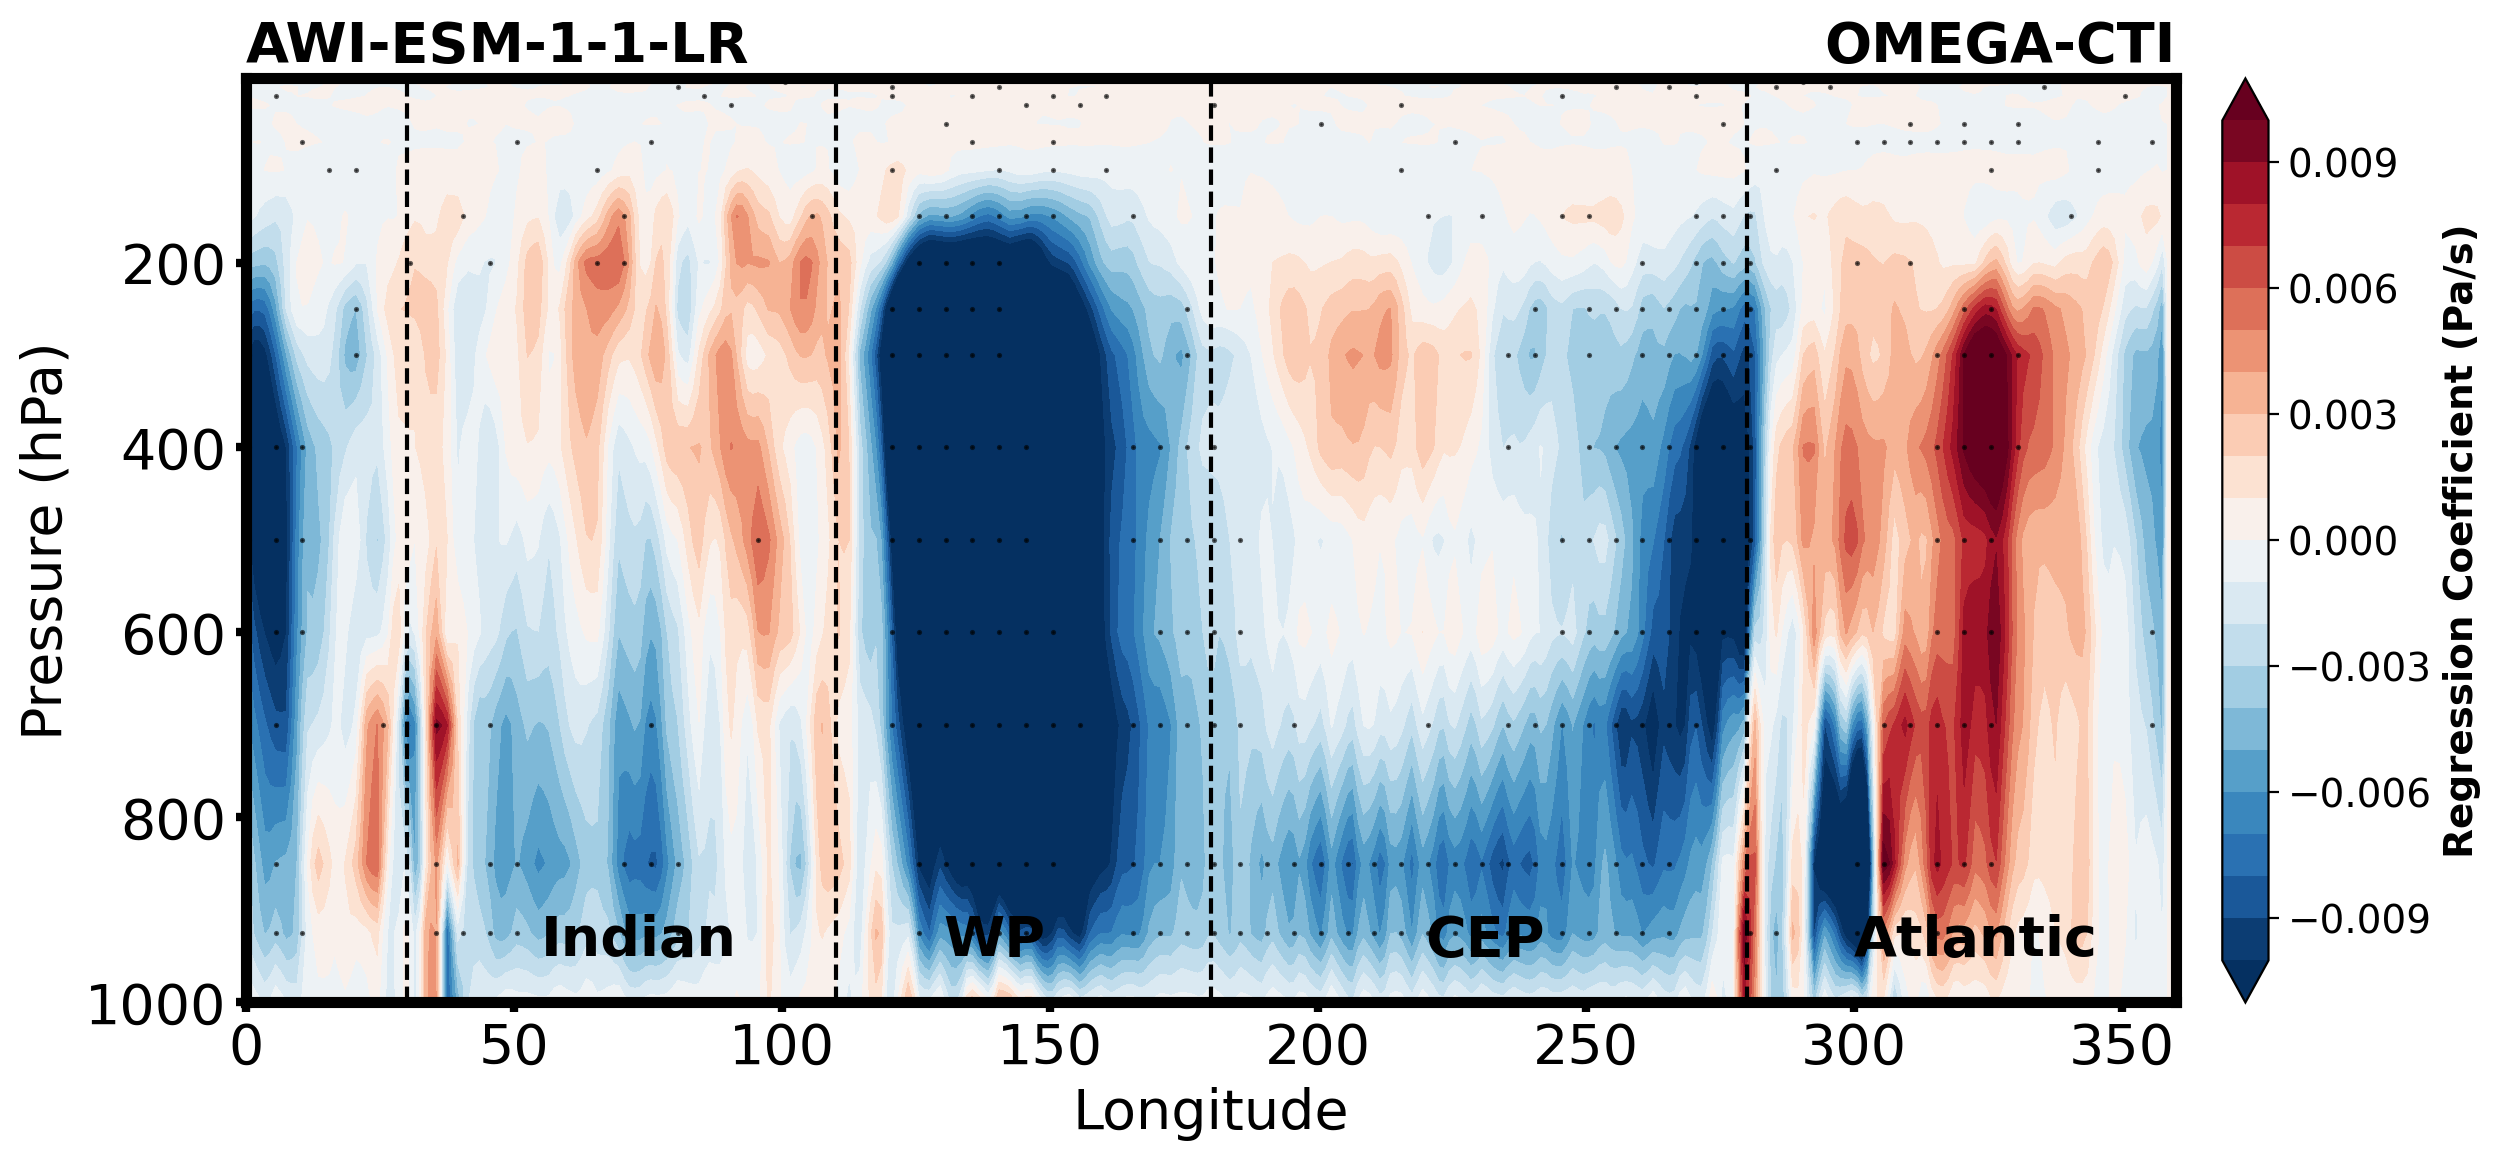

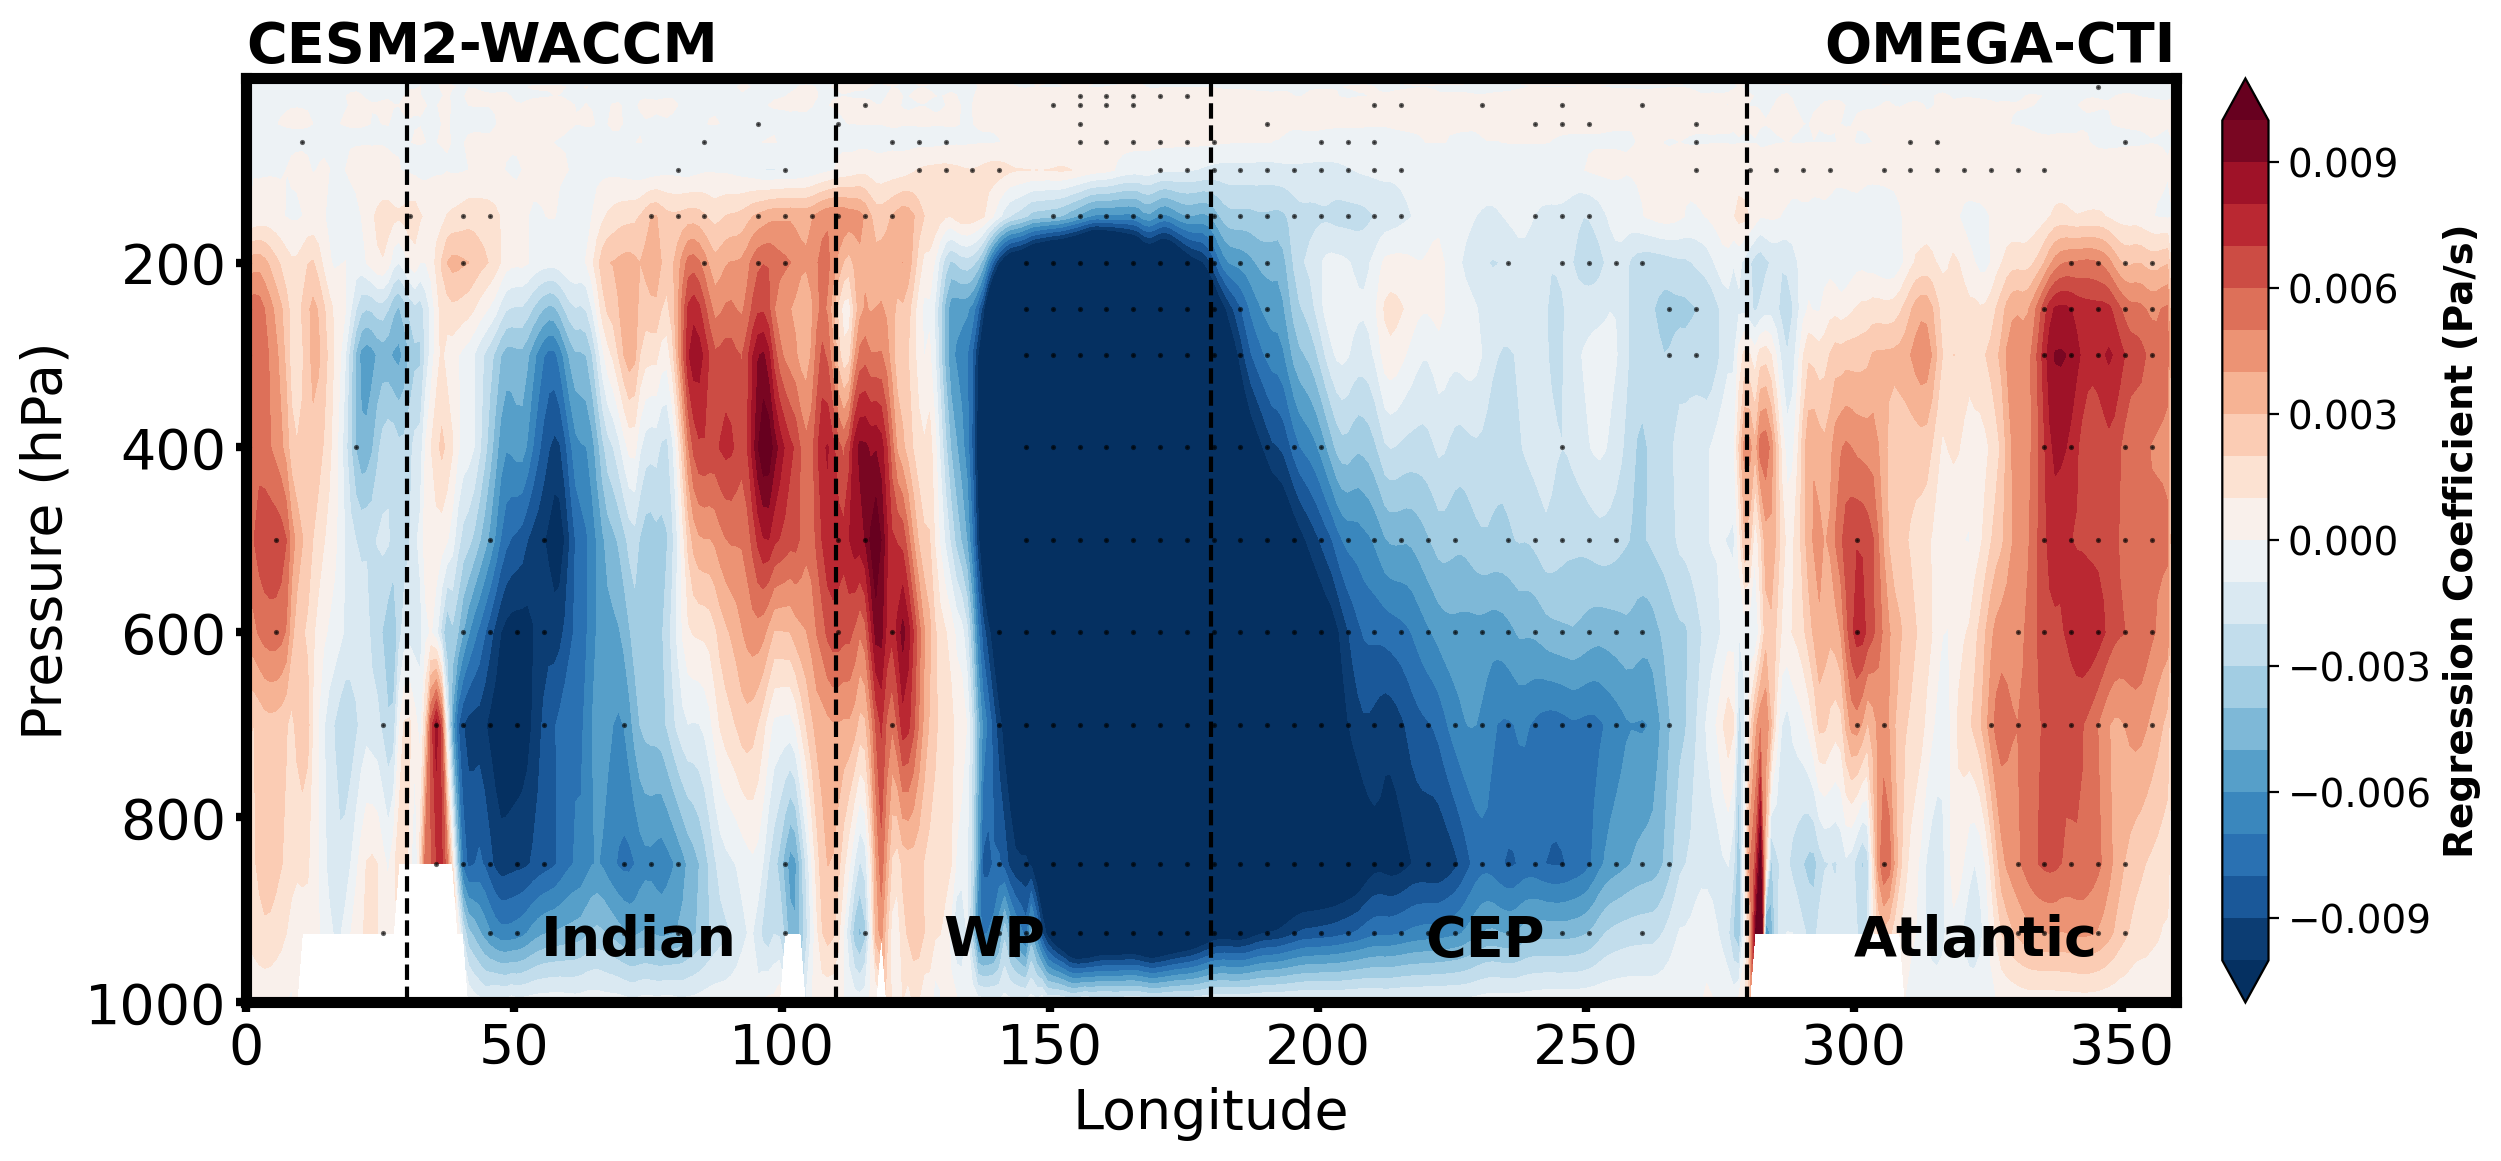

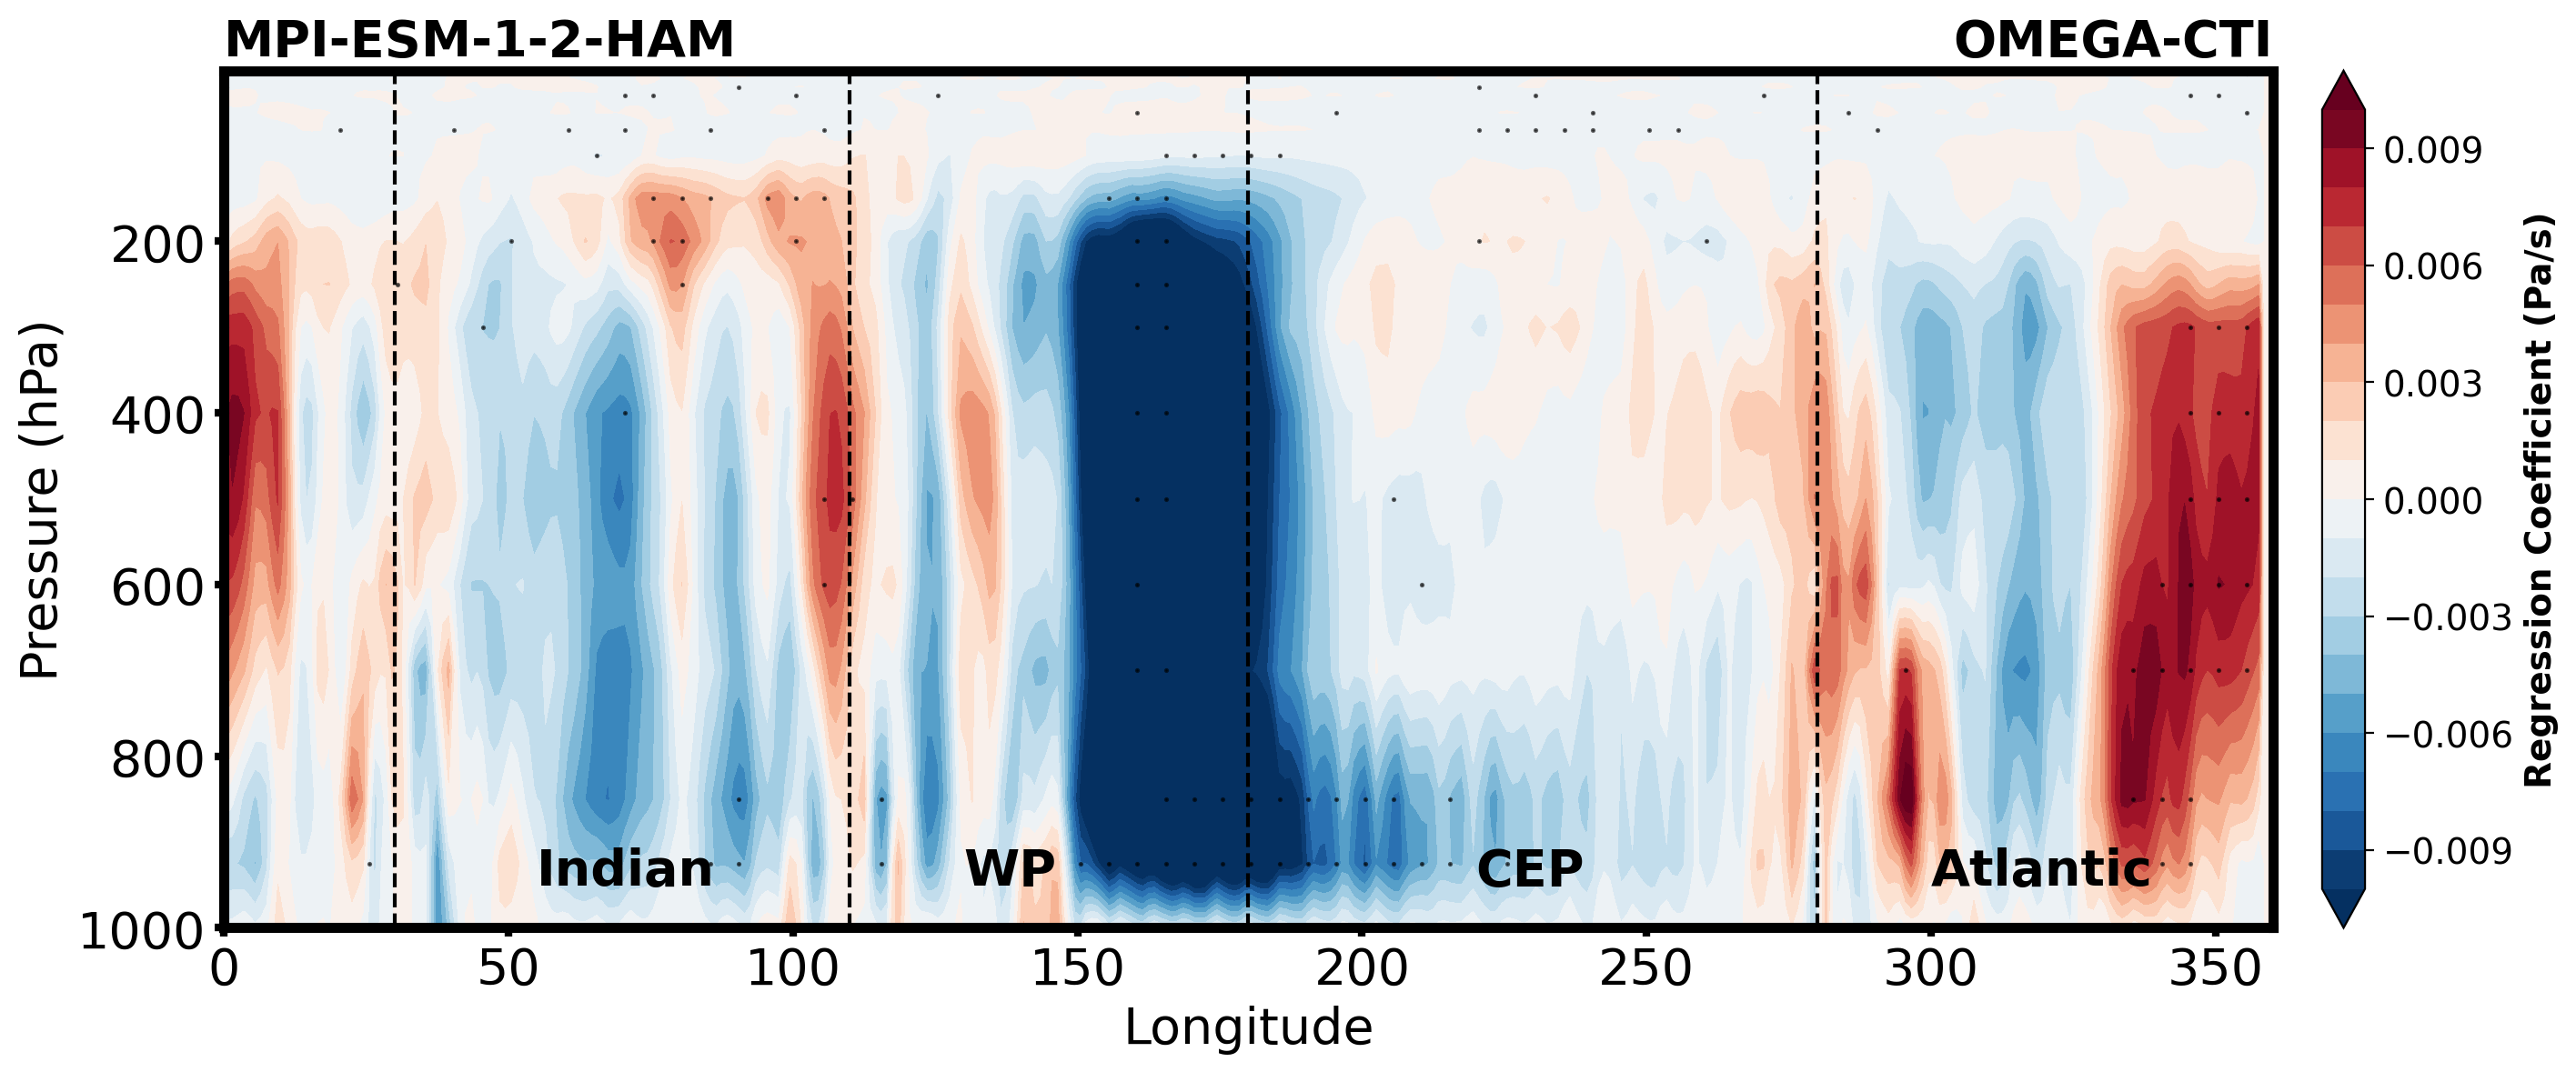

In [11]:


plot_wind_profile(high_skill_omega_nta, left_title='High-Skill MMM', right_title='OMEGA-NTA', vmin=-0.01, vmax=0.01, interval=0.001, threshold=0.621489, significance_mask_ds=significance_mask_ds_nta_high)
for model in high_skill_models:
    plot_wind_profile(reg_nta_omega_cmip[model], left_title=model, right_title='OMEGA-NTA', vmin=-0.01, vmax=0.01, interval=0.001, threshold=0.621489)

plot_wind_profile(high_skill_omega_cti, left_title='High-Skill MMM', right_title='OMEGA-CTI', vmin=-0.01, vmax=0.01, interval=0.001, threshold=0.621489, significance_mask_ds=significance_mask_ds_cti_high)
for model in high_skill_models:
    plot_wind_profile(reg_cti_omega_cmip[model], left_title=model, right_title='OMEGA-CTI', vmin=-0.01, vmax=0.01, interval=0.001, threshold=0.621489)
plt.tight_layout()


## 3. Plot the Z200 regression coefficient of the high and low skill models

In [8]:
path = '../data/processed/regression/'


reg_nta_z200_cmip = load_from_pickle(path+'reg_nta_z200_cmip.pkl')
reg_cti_z200_cmip = load_from_pickle(path+'reg_cti_z200_cmip.pkl')

reg_nta_z200_2 = load_from_pickle(path+'reg_nta_z200_e3sm.pkl')
reg_cti_z200_2 = load_from_pickle(path+'reg_cti_z200_e3sm.pkl')

CMIP6_MODLES = '../data/raw/source_id.txt'

In [9]:
# convert reg_nta_z200_cmip from list to dictionary
reg_nta_z200_dict = {}
reg_cti_z200_dict = {}


for i, model in enumerate(cmip_models):
    model = model.split('.')[0] 
    reg_nta_z200_dict[model] = reg_nta_z200_cmip[i]
    reg_cti_z200_dict[model] = reg_cti_z200_cmip[i]

# update the original variable
reg_nta_z200_cmip = reg_nta_z200_dict
reg_cti_z200_cmip = reg_cti_z200_dict

reg_nta_z200_2_dict = {}
reg_cti_z200_2_dict = {}

for i, model in enumerate(models_extend):
    model = model.split('.')[0]  
    reg_nta_z200_2_dict[model] = reg_nta_z200_2[i]
    reg_cti_z200_2_dict[model] = reg_cti_z200_2[i]

reg_nta_z200_2 = reg_nta_z200_2_dict
reg_cti_z200_2 = reg_cti_z200_2_dict


In [10]:
# Calculate ensemble mean for high and low skill models
high_skill_z200_nta = {}

high_skill_z200_cti = {}


# calculate the ensemble mean for high and low skill models
for var in ['slope', 'intercept', 'r_value', 'p_value', 'std_err']:
    # high skill models
    high_skill_nta_data = np.stack([reg_nta_z200_cmip[model][var].values 
                               for model in high_skill_models if model in reg_nta_z200_cmip])
    high_skill_z200_nta[var] = xr.DataArray(
        np.nanmean(high_skill_nta_data, axis=0),
        coords=reg_nta_z200_cmip[list(reg_nta_z200_cmip.keys())[0]][var].coords
    )
    
    high_skill_cti_data = np.stack([reg_cti_z200_cmip[model][var].values 
                               for model in high_skill_models if model in reg_cti_z200_cmip])
    high_skill_z200_cti[var] = xr.DataArray(
        np.nanmean(high_skill_cti_data, axis=0),
        coords=reg_cti_z200_cmip[list(reg_cti_z200_cmip.keys())[0]][var].coords
    )


# convert the result to xarray dataset
high_skill_z200_nta = xr.Dataset(high_skill_z200_nta)

high_skill_z200_cti = xr.Dataset(high_skill_z200_cti)


# add to the regression dictionary
reg_nta_z200_cmip['High-Skill-MMM'] = high_skill_z200_nta

reg_cti_z200_cmip['High-Skill-MMM'] = high_skill_z200_cti



In [13]:
# Calculate significance masks for high-skill and low-skill model groups
high_skill_nta_z200_significance_mask = calculate_significance(high_skill_models, reg_nta_z200_cmip)
high_skill_cti_z200_significance_mask = calculate_significance(high_skill_models, reg_cti_z200_cmip)



In [14]:
################## Plot ###########################
def plot_z3_regression_correlation_map(ax, data, variable, title, vmin=-0.1, vmax=0.1, interval=0.1, model=None, significance_mask=None):
    # Extract the data to be plotted
    data_to_plot = data[variable]
    
    
    lats = data_to_plot['lat']
    lons = data_to_plot['lon']

    interval = (vmax-vmin)/10
    
    warm_levels = np.arange(0, vmax, interval)
    negative_levels = np.arange(vmin, 0, interval)
   

    # Plot the data
    im = ax.pcolormesh(data_to_plot['lon'], data_to_plot['lat'], data_to_plot,
                       transform=ccrs.PlateCarree(), cmap='RdBu_r', vmin=vmin, vmax=vmax,)
    
    # ax.contour(data_to_plot['lon'], data_to_plot['lat'], data_to_plot, colors='k', levels=[0.2], linestyles='-')
    ax.contour(data_to_plot['lon'], data_to_plot['lat'], data_to_plot, levels=warm_levels, 
               colors='gray', linestyles='-', transform=ccrs.PlateCarree())
    
    # ax.contour(data_to_plot['lon'], data_to_plot['lat'], data_to_plot, colors='k', levels=[0.2], linestyles='-')
    ax.contour(data_to_plot['lon'], data_to_plot['lat'], data_to_plot, levels=negative_levels, 
               colors='gray', linestyles=':', transform=ccrs.PlateCarree())

 
    if model in ['High-Skill-MMM', 'Low-Skill-MMM']:
        plot_significant_dots_cmip_mmm(ax, lons=lons, lats=lats, significance_mask=significance_mask, thinning_factor=6)    
    else:
        data_masked = data['r_value']
        plot_significant_dots(ax, lons=lons, lats=lats, data=data_masked, r_threshold=0.621489, thinning_factor=6)

    # Add coastlines for context
    ax.coastlines()
    
    # Set title for the subplot
    ax.set_title(title)
    
    # Add gridlines and labels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.4, linestyle='--')
    gl.top_labels = False  # Disable labels at the top
    gl.right_labels = False  # Disable labels on the right
    
    # # Draw a box for 'cti'
    cti_box = mpatches.Rectangle((180, -6), 90, 12, fill=False, edgecolor='black', linewidth=2, transform=ccrs.PlateCarree())
    ax.add_patch(cti_box)


    return im

def plot_significant_dots(ax, data, lons, lats, r_threshold, thinning_factor=6):
    significant_mask = abs(data) >= r_threshold
    stipple_lons, stipple_lats = np.meshgrid(lons, lats)
    thin_mask = significant_mask[::thinning_factor, ::thinning_factor]
    thin_stipple_lons = stipple_lons[::thinning_factor, ::thinning_factor]
    thin_stipple_lats = stipple_lats[::thinning_factor, ::thinning_factor]
    ax.scatter(thin_stipple_lons[thin_mask], thin_stipple_lats[thin_mask], 
            color='k', marker='.', s=5, alpha=0.6, transform=ccrs.PlateCarree())  # Adjust size `s` and transparency `alpha` as needed


# Function to create significant mask and plot the dots for CMIP_MMM
def plot_significant_dots_cmip_mmm(ax, lons, lats, significance_mask, thinning_factor=6):
    stipple_lons, stipple_lats = np.meshgrid(lons, lats)
    thin_mask = significance_mask[::thinning_factor, ::thinning_factor]
    thin_stipple_lons = stipple_lons[::thinning_factor, ::thinning_factor]
    thin_stipple_lats = stipple_lats[::thinning_factor, ::thinning_factor]
    ax.scatter(thin_stipple_lons[thin_mask], thin_stipple_lats[thin_mask], 
            color='k', marker='.', s=5, alpha=0.6, transform=ccrs.PlateCarree())  # Adjust size `s` and transparency `alpha` as needed


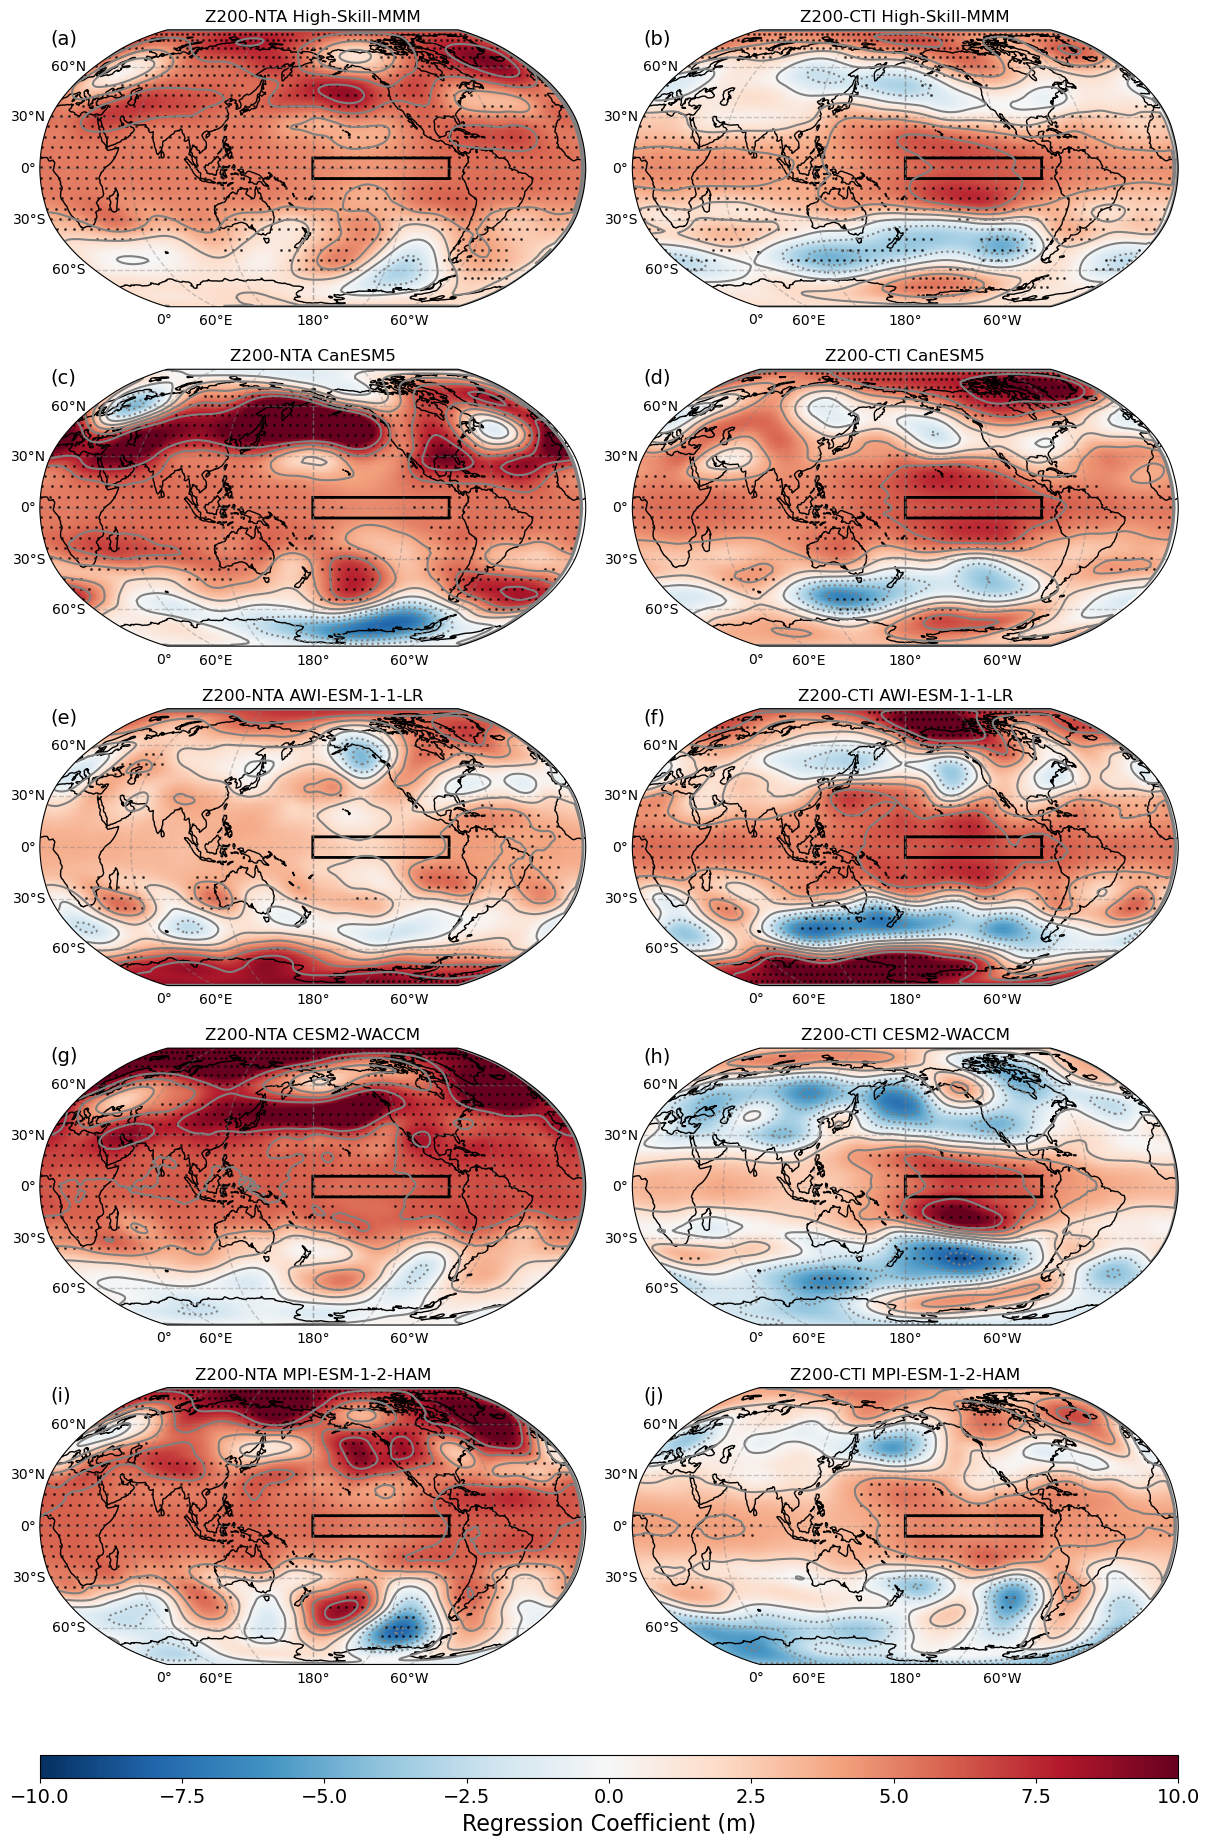

In [16]:
# create a 5x2 subplot layout
fig, axe = plt.subplots(5, 2, figsize=(12, 20), 
                        subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})

# left column: NTA
# first row: High-Skill MMM
im1 = plot_z3_regression_correlation_map(axe[0,0], high_skill_z200_nta, 'slope', 
                                       'Z200-NTA High-Skill-MMM', model='High-Skill-MMM', 
                                       significance_mask=high_skill_nta_z200_significance_mask, 
                                       vmin=-10, vmax=10)

# next 4 rows: individual models
for i, model in enumerate(high_skill_models[:4], start=1):
    im = plot_z3_regression_correlation_map(axe[i,0], reg_nta_z200_cmip[model], 'slope', 
                                          f'Z200-NTA {model}', model=model, 
                                          significance_mask=None, vmin=-10, vmax=10)

# right column: CTI
# first row: High-Skill MMM
im2 = plot_z3_regression_correlation_map(axe[0,1], high_skill_z200_cti, 'slope', 
                                       'Z200-CTI High-Skill-MMM', model='High-Skill-MMM', 
                                       significance_mask=high_skill_cti_z200_significance_mask, 
                                       vmin=-10, vmax=10)

# next 4 rows: individual models
for i, model in enumerate(high_skill_models[:4], start=1):
    im = plot_z3_regression_correlation_map(axe[i,1], reg_cti_z200_cmip[model], 'slope', 
                                          f'Z200-CTI {model}', model=model, 
                                          significance_mask=None, vmin=-10, vmax=10)

# add subplot labels
labels_left = ['(a)', '(c)', '(e)', '(g)', '(i)']
labels_right = ['(b)', '(d)', '(f)', '(h)', '(j)']

for i, (label_left, label_right) in enumerate(zip(labels_left, labels_right)):
    axe[i,0].text(0.02, 0.95, label_left, transform=axe[i,0].transAxes, fontsize=14)
    axe[i,1].text(0.02, 0.95, label_right, transform=axe[i,1].transAxes, fontsize=14)

# adjust the layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# add colorbar
cbar = fig.colorbar(im1, ax=axe.ravel().tolist(), orientation='horizontal', 
                    fraction=0.015,  # control the height of the colorbar
                    pad=0.05,        # control the distance between the colorbar and the plot
                    aspect=50)       # control the width ratio of the colorbar

# set the label of the colorbar
label = 'Regression Coefficient (m)'
cbar.set_label(label, fontsize=16)
cbar.ax.tick_params(labelsize=14)

plt.show()

In [80]:
len(low_skill_models)


15